*Research Question:* Is the relationship between high-amplitude QSWs and extreme cold events in North America changing over time according to historical observations 1979-2022?

In [1]:
import xarray as xr
import numpy as np
import cftime
from scipy.stats import linregress
import pymannkendall as mk
import datetime as dt
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from cartopy import config as cfg
import dask
from dask.distributed import Client, LocalCluster

print("Cartopy data dir:", cfg['data_dir'])

Cartopy data dir: /home/nedroos/.local/share/cartopy


In [2]:
# path to your local shapefile
shp_path = "/home/nedroos/.local/share/cartopy/shapefiles/natural_earth/physical/ne_110m_coastline.shp"

# create coastline from shapefile
coastline = cfeature.ShapelyFeature(
    shpreader.Reader(shp_path).geometries(),
    ccrs.PlateCarree(),
    facecolor='none',
    edgecolor='black',
    linewidth=0.5
)

In [3]:
# set up parallel computing
client = Client(LocalCluster(n_workers=20))
print(client)

/home/nedroos/.conda/envs/nazenv_py.3.13.4/lib/python3.1/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35857 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:45039' processes=20 threads=20, memory=80.00 GiB>


In [4]:
def manntrend(dat):
    dat = np.asarray(dat)
    if not np.isnan(dat).all() and np.count_nonzero(~np.isnan(dat)) > 1:
        trend = mk.original_test(dat)
        slope = trend[-2]
        pval = trend[2]
    else:
        slope = 0
        pval = 1
    return slope, pval

# Reading in Data

In [5]:
winter_qsw = xr.open_dataset("/scratch/st-rwhite01-1/data_shared/QSW_ERA5_DJF_NH.nc")
winter_qsw

<xarray.Dataset> Size: 386MB
Dimensions:    (time: 4675, latitude: 43, longitude: 240)
Coordinates:
  * time       (time) datetime64[ns] 37kB 1979-01-08 1979-01-09 ... 2022-12-24
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
    dayofyear  (time) int64 37kB ...
Data variables:
    q          (time, latitude, longitude) float64 386MB ...

In [6]:
daily_min = xr.open_dataset("/scratch/st-rwhite01-1/data_shared/era5_tmin_regrid_1979-2022_DJF.nc")
daily_min

<xarray.Dataset> Size: 163MB
Dimensions:    (time: 3940, longitude: 240, latitude: 43)
Coordinates:
  * time       (time) datetime64[ns] 32kB 1979-01-01 1979-01-02 ... 2022-02-28
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
Data variables:
    t2m        (time, latitude, longitude) float32 163MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.5.0 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Wed Jul 30 10:38:15 2025: cdo remapcon,QSW_ERA5_...
    CDO:                     Climate Data Operators version 2.5.0 (https://mp...

In [7]:
coldwave_winter = xr.open_dataset("/scratch/st-rwhite01-1/data_shared/era5_colddays_1979_2022_regrid_new.nc")
coldwave_winter

<xarray.Dataset> Size: 318MB
Dimensions:    (time: 3856, longitude: 240, latitude: 43)
Coordinates:
  * time       (time) object 31kB 1979-12-08 00:00:00 ... 2022-02-21 00:00:00
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
    dayofyear  (time) int64 31kB ...
Data variables:
    t2m        (time, latitude, longitude) float64 318MB ...

In [3]:
summer_qsw = xr.open_dataset("/scratch/st-rwhite01-1/data_shared/era5_JJA_qsw_1979-2022.nc")
summer_qsw["longitude"] = xr.apply_ufunc(lambda x: x - 180, summer_qsw['longitude'])
summer_qsw

<xarray.Dataset> Size: 941MB
Dimensions:    (time: 4048, latitude: 121, longitude: 240)
Coordinates:
  * time       (time) datetime64[ns] 32kB 1979-06-01 1979-06-02 ... 2022-08-31
  * latitude   (latitude) float32 484B 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float32 960B -180.0 -178.5 -177.0 ... 177.0 178.5
    level      (time) int32 16kB ...
    dayofyear  (time) int64 32kB ...
Data variables:
    q          (time, latitude, longitude) float64 940MB ...

# Preliminary data plotting

## Mean Climatology of Quasi-Stationary Waves

In [4]:
# summer
summer_qsw_mean = summer_qsw.groupby("time.season").mean()
summer_qsw_mean_clean = summer_qsw_mean.where(summer_qsw_mean["q"] != 0, drop=True)
summer_qsw_mean_clean

<xarray.Dataset> Size: 84kB
Dimensions:    (season: 1, latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float32 172B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float32 960B -180.0 -178.5 -177.0 ... 177.0 178.5
  * season     (season) object 8B 'JJA'
Data variables:
    q          (season, latitude, longitude) float64 83kB 9.303 9.315 ... 2.057

In [5]:
# winter
winter_fall_mean = winter_qsw.groupby("time.season").mean()
winter_qsw_mean = winter_fall_mean.sel(season="DJF")
winter_qsw_mean_clean = winter_qsw_mean.where(winter_qsw_mean["q"] != 0, drop=True)
winter_qsw_mean_clean

<xarray.Dataset> Size: 85kB
Dimensions:    (latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
    season     <U3 12B 'DJF'
Data variables:
    q          (latitude, longitude) float64 83kB 10.28 10.27 ... 5.484 5.614

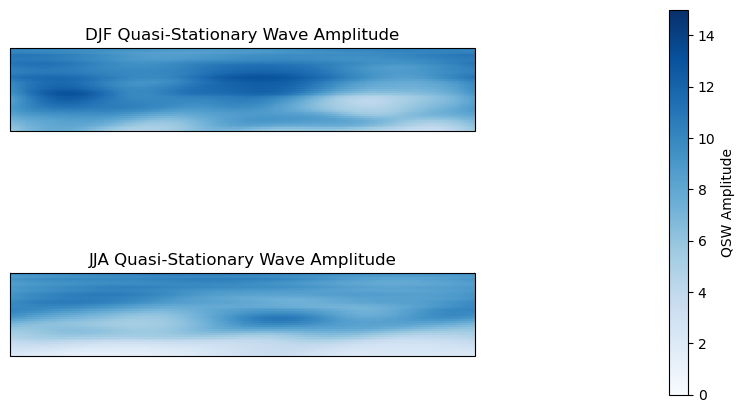

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

wq2d = winter_qsw_mean_clean["q"]
winter_qsw_plot = wq2d.plot.pcolormesh(cmap="Blues", vmin=0, vmax=15, transform=ccrs.PlateCarree(), ax=axs[0], add_colorbar=False)
axs[0].set_title("DJF Quasi-Stationary Wave Amplitude")

sq2d = summer_qsw_mean_clean["q"].sel(season="JJA")
summer_qsw_plot = sq2d.plot.pcolormesh(cmap="Blues", vmin=0, vmax=15, transform=ccrs.PlateCarree(), ax=axs[1], add_colorbar=False)
axs[1].set_title("JJA Quasi-Stationary Wave Amplitude")

# create shared ScalarMappable
norm = colors.Normalize(vmin=0, vmax=15)
sm = cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])

# add shared colorbar
plt.subplots_adjust(hspace=0.4)
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', pad=0.25)
cbar.set_label('QSW Amplitude')

plt.show()

## Plotting a decadal trend map of DJF Quasi-Stationary Waves 1979-2022

In [99]:
# split dataset by decade

# create a new coordinate for decade
winter_qsw = winter_qsw.assign_coords(
    decade=(winter_qsw.time.dt.year // 10) * 10
)

# compute the decadal mean
winter_decadal_means = winter_qsw.groupby('decade').mean()

# extract the decade values
decades = winter_decadal_means.decade.values

winter_decadal_means

<xarray.Dataset> Size: 498kB
Dimensions:    (decade: 6, latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
  * decade     (decade) int64 48B 1970 1980 1990 2000 2010 2020
Data variables:
    q          (decade, latitude, longitude) float64 495kB 9.348 9.351 ... 5.437

In [100]:
# initialize trends array
trends = np.empty((winter_decadal_means.latitude.shape[0], winter_decadal_means.longitude.shape[0]))

# calculate linear trend at each point
for x in range(winter_decadal_means.latitude.shape[0]):
    for y in range(winter_decadal_means.longitude.shape[0]):
        # linear regression for grid cell
        grid_trend = linregress(decades, winter_decadal_means["q"][:, x, y].values)
        # add regression value to array of trends
        trends[x, y] = grid_trend.slope

trends

array([[ 0.00719214,  0.00673252,  0.00627936, ...,  0.00860255,
         0.00812737,  0.00765724],
       [ 0.00284469,  0.00226006,  0.00168076, ...,  0.00463527,
         0.00403155,  0.00343485],
       [ 0.00354673,  0.00272522,  0.00190807, ...,  0.00601021,
         0.00518952,  0.00436898],
       ...,
       [-0.01435944, -0.01291232, -0.0113839 , ..., -0.01808639,
        -0.01695192, -0.01570798],
       [-0.01850015, -0.01693395, -0.01524034, ..., -0.02225576,
        -0.02117961, -0.01992792],
       [-0.02053011, -0.01890016, -0.01714816, ..., -0.02444835,
        -0.02333167, -0.02202082]], shape=(43, 240))

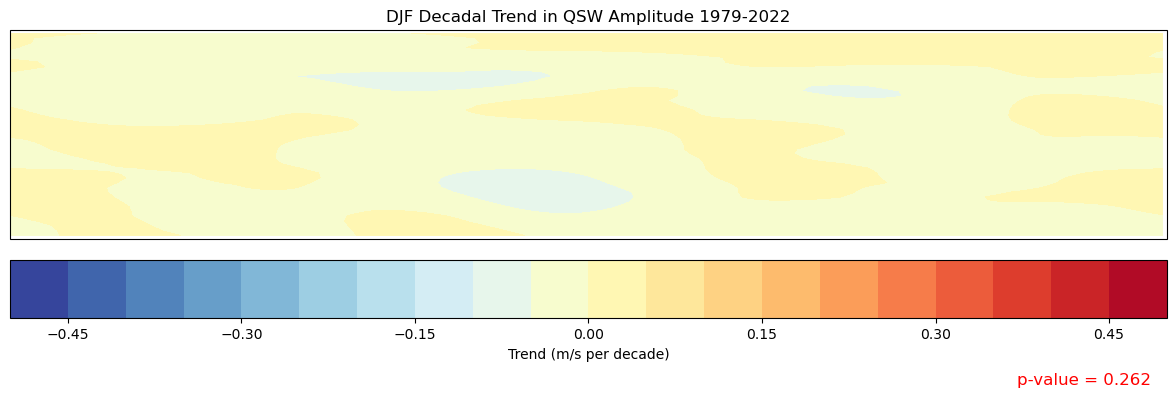

In [101]:
# plot trend map
lon2d, lat2d = np.meshgrid(winter_decadal_means.longitude, winter_decadal_means.latitude)

fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

c = ax.contourf(lon2d, lat2d, trends,
                levels=np.linspace(-0.5, 0.5, 21),
                cmap='RdYlBu_r',
                transform=ccrs.PlateCarree())
ax.set_title("DJF Decadal Trend in QSW Amplitude 1979-2022")
ax.set_extent([-180, 180, 20, 85], crs=ccrs.PlateCarree())

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend (m/s per decade)")

p_value = "p-value = " + str(round(grid_trend.pvalue, 3))
text_kwargs = dict(fontsize=12, color="red")
ax.text(0.87, -0.7, p_value, transform=ax.transAxes, **text_kwargs)

plt.tight_layout()
plt.show()

# Annual Mann-Kendall trend map of DJF QSWs 1979-2022

In [43]:
# group data by year
winter_qsw_yearly = winter_qsw.groupby("time.year").mean(dim='time', skipna=True)
winter_qsw_yearly

<xarray.Dataset> Size: 4MB
Dimensions:    (year: 44, latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
  * year       (year) int64 352B 1979 1980 1981 1982 ... 2019 2020 2021 2022
Data variables:
    q          (year, latitude, longitude) float64 4MB 9.348 9.351 ... 5.556

In [44]:
# initialize trends array
# trends = np.empty((winter_qsw_yearly.latitude.shape[0], winter_qsw_yearly.longitude.shape[0]))
# years = np.unique(winter_qsw_yearly["year"])

# # calculate linear trend at each point
# for x in range(winter_qsw_yearly.latitude.shape[0]):
#     for y in range(winter_qsw_yearly.longitude.shape[0]):
#         # linear regression for grid cell
#         grid_trend = linregress(years, winter_qsw_yearly["q"][:, x, y].values)
#         # add regression value to array of trends
#         trends[x, y] = grid_trend.slope

# trends

slope1, pval1 = xr.apply_ufunc(
    manntrend,
    winter_qsw_yearly,
    input_core_dims=[['year']],
    output_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float]
)

slope1

<xarray.Dataset> Size: 85kB
Dimensions:    (latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
Data variables:
    q          (latitude, longitude) float64 83kB -0.004661 -0.005759 ... 0.0125

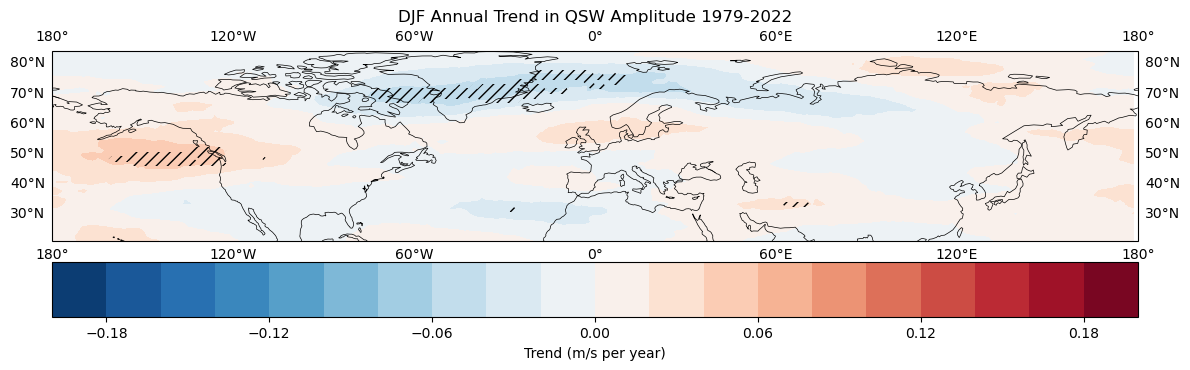

In [45]:
# plot trend map
lon2d, lat2d = np.meshgrid(winter_qsw_yearly.longitude, winter_qsw_yearly.latitude)
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

c = ax.contourf(slope1.longitude,
                slope1.latitude,
                slope1.q,
                levels=np.linspace(-0.2, 0.2, 21),
                cmap="RdBu_r",
                transform=ccrs.PlateCarree())
ax.set_title("DJF Annual Trend in QSW Amplitude 1979-2022")
ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend (m/s per year)")

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False

# mask p < 0.05 with hatching
sig_mask = (pval1["q"] < 0.05)
ax.contourf(lon2d, lat2d, sig_mask, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

# Annual Mann-Kendall trend of DJF *high-amplitude* QSWs 1979-2022

## By value

### 90th percentile

In [13]:
# first, filter dataset to obtain 90th percentile high-amplitude QSWs
winter_quantile_90 = winter_qsw.quantile(q=0.9)["q"].item()
amp_90_winter_qsw = winter_qsw.where(winter_qsw["q"] > winter_quantile_90)
amp_90_winter_qsw

<xarray.Dataset> Size: 386MB
Dimensions:    (time: 4675, latitude: 43, longitude: 240)
Coordinates:
  * time       (time) datetime64[ns] 37kB 1979-01-08 1979-01-09 ... 2022-12-24
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
    dayofyear  (time) int64 37kB 8 9 10 11 12 13 14 ... 353 354 355 356 357 358
Data variables:
    q          (time, latitude, longitude) float64 386MB 19.4 19.46 ... nan nan

In [14]:
# group data by year
amp_90_winter_qsw_yearly = amp_90_winter_qsw.groupby("time.year").mean(dim='time', skipna=True)
amp_90_winter_qsw_yearly

<xarray.Dataset> Size: 4MB
Dimensions:    (year: 44, latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
  * year       (year) int64 352B 1979 1980 1981 1982 ... 2019 2020 2021 2022
Data variables:
    q          (year, latitude, longitude) float64 4MB 19.35 19.25 ... nan nan

In [15]:
# initialize trends array
# trends = np.full((amp_90_winter_qsw_yearly.latitude.shape[0], amp_90_winter_qsw_yearly.longitude.shape[0]), np.nan)
# years = np.unique(amp_90_winter_qsw_yearly["year"])

# calculate linear trend at each point
# for x in range(amp_90_winter_qsw_yearly.latitude.shape[0]):
#     for y in range(amp_90_winter_qsw_yearly.longitude.shape[0]):
#         y_vals = amp_90_winter_qsw_yearly["q"][:, x, y].values

#         # remove NaNs and match years
#         mask = ~np.isnan(y_vals)
#         y_clean = y_vals[mask]
#         years_clean = years[mask]

#         if len(y_clean) < 2:
#             continue  # not enough data to do regression
        
#         # linear regression for grid cell
#         grid_trend = linregress(years_clean, y_clean)
#         # add regression value to array of trends
#         trends[x, y] = grid_trend.slope

# trends

slope2, pval2 = xr.apply_ufunc(
    manntrend,
    amp_90_winter_qsw_yearly,
    input_core_dims=[['year']],
    output_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float]
)

slope2

<xarray.Dataset> Size: 85kB
Dimensions:    (latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
Data variables:
    q          (latitude, longitude) float64 83kB -0.0292 -0.02963 ... -0.002126

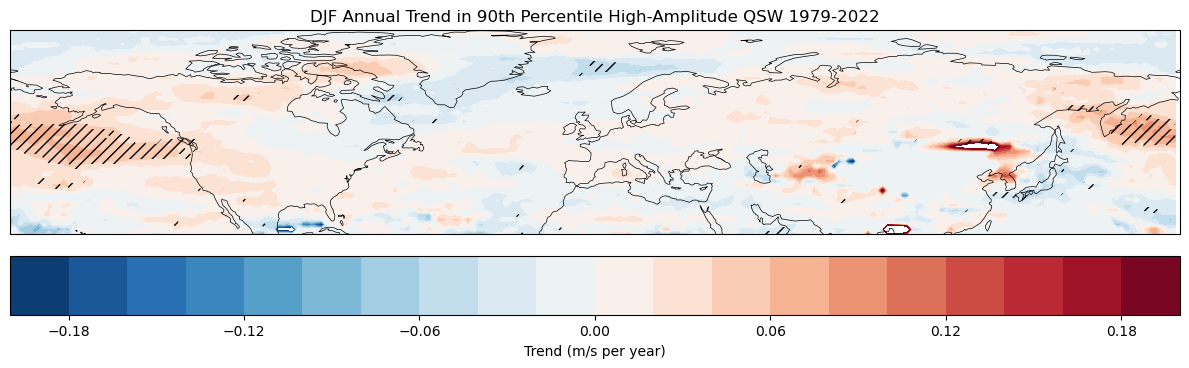

In [16]:
# plot linear trend map
# lon2d, lat2d = np.meshgrid(amp_90_winter_qsw_yearly.longitude, amp_90_winter_qsw_yearly.latitude)

# fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# c = ax.contourf(lon2d, lat2d, slope,
#                 levels=np.linspace(-0.5, 0.5, 21),
#                 cmap='RdYlBu_r',
#                 transform=ccrs.PlateCarree())
# ax.set_title("DJF Annual Trend in 90th Percentile High-Amplitude QSW 1979-2022")
# ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())

# cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
# cbar.set_label("Trend (m/s per year)")

# p_value = "p-value = " + str(round(pval, 3))
# text_kwargs = dict(fontsize=12, color="red")
# ax.text(0.87, -0.7, p_value, transform=ax.transAxes, **text_kwargs)

# plt.tight_layout()
# plt.show()

# plot mann kendall trend
lon2d, lat2d = np.meshgrid(amp_90_winter_qsw_yearly.longitude, amp_90_winter_qsw_yearly.latitude)
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(slope2.longitude,
                slope2.latitude,
                slope2.q,
                levels=np.linspace(-0.2, 0.2, 21),
                cmap="RdBu_r",
                transform=ccrs.PlateCarree())
ax.set_title("DJF Annual Trend in 90th Percentile High-Amplitude QSW 1979-2022")
ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend (m/s per year)")

# mask p < 0.05 with hatching
sig_mask = (pval2["q"] < 0.05)
ax.contourf(lon2d, lat2d, sig_mask, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

### 75th percentile (IGNORE)

In [27]:
# first, filter dataset to obtain 75th percentile high-amplitude QSWs
winter_quantile_75 = winter_qsw.quantile(q=0.75)["q"].item()
amp_75_winter_qsw = winter_qsw.where(winter_qsw["q"] > winter_quantile_75)
amp_75_winter_qsw

<xarray.Dataset> Size: 386MB
Dimensions:    (time: 4675, latitude: 43, longitude: 240)
Coordinates:
  * time       (time) datetime64[ns] 37kB 1979-01-08 1979-01-09 ... 2022-12-24
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
    dayofyear  (time) int64 37kB 8 9 10 11 12 13 14 ... 353 354 355 356 357 358
Data variables:
    q          (time, latitude, longitude) float64 386MB 19.4 19.46 ... nan nan

In [28]:
# group data by year
amp_75_winter_qsw_yearly = amp_75_winter_qsw.groupby("time.year").mean(dim='time', skipna=True)
amp_75_winter_qsw_yearly

<xarray.Dataset> Size: 4MB
Dimensions:    (year: 44, latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
  * year       (year) int64 352B 1979 1980 1981 1982 ... 2019 2020 2021 2022
Data variables:
    q          (year, latitude, longitude) float64 4MB 16.52 16.56 ... nan nan

In [29]:
# initialize trends array
# trends = np.full((amp_75_winter_qsw_yearly.latitude.shape[0], amp_75_winter_qsw_yearly.longitude.shape[0]), np.nan)
# years = np.unique(amp_75_winter_qsw_yearly["year"])

# calculate linear trend at each point
# for x in range(amp_75_winter_qsw_yearly.latitude.shape[0]):
#     for y in range(amp_75_winter_qsw_yearly.longitude.shape[0]):
#         y_vals = amp_75_winter_qsw_yearly["q"][:, x, y].values

#         # remove NaNs and match years
#         mask = ~np.isnan(y_vals)
#         y_clean = y_vals[mask]
#         years_clean = years[mask]

#         if len(y_clean) < 2:
#             continue  # not enough data to do regression
        
#         # linear regression for grid cell
#         grid_trend = linregress(years_clean, y_clean)
#         # add regression value to array of trends
#         trends[x, y] = grid_trend.slope

# trends

slope, pval = xr.apply_ufunc(
    manntrend,
    amp_75_winter_qsw_yearly,
    input_core_dims=[['year']],
    output_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float]
)

slope

<xarray.Dataset> Size: 85kB
Dimensions:    (latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
Data variables:
    q          (latitude, longitude) float64 83kB -0.02107 -0.02142 ... -0.02332

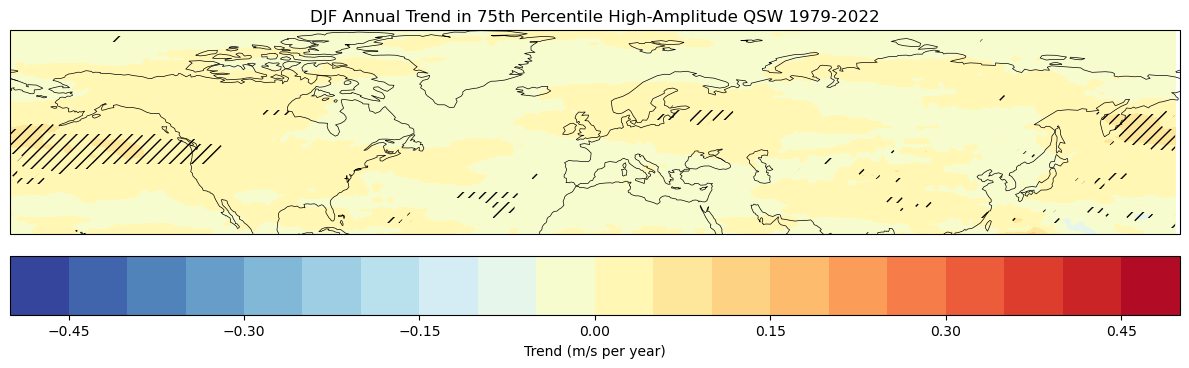

In [30]:
# plot trend map
# lon2d, lat2d = np.meshgrid(amp_90_winter_qsw_yearly.longitude, amp_90_winter_qsw_yearly.latitude)

# fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# c = ax.contourf(lon2d, lat2d, trends,
#                 levels=np.linspace(-0.5, 0.5, 21),
#                 cmap='RdYlBu_r',
#                 transform=ccrs.PlateCarree())
# ax.set_title("DJF Annual Trend in 75th Percentile High-Amplitude QSW 1979-2022")
# ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())

# cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
# cbar.set_label("Trend (m/s per year)")

# p_value = "p-value = " + str(round(grid_trend.pvalue, 3))
# text_kwargs = dict(fontsize=12, color="red")
# ax.text(0.87, -0.7, p_value, transform=ax.transAxes, **text_kwargs)

# plt.tight_layout()
# plt.show()

# plot mann kendall trend
lon2d, lat2d = np.meshgrid(amp_90_winter_qsw_yearly.longitude, amp_90_winter_qsw_yearly.latitude)
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(slope.longitude,
                slope.latitude,
                slope.q,
                levels=np.linspace(-0.5, 0.5, 21),
                cmap="RdYlBu_r",
                transform=ccrs.PlateCarree())
ax.set_title("DJF Annual Trend in 75th Percentile High-Amplitude QSW 1979-2022")
ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend (m/s per year)")

# mask p < 0.05 with hatching
sig_mask = (pval["q"] < 0.05)
ax.contourf(lon2d, lat2d, sig_mask, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

## By number of occurrences (these are individual tallies so IGNORE)

### 90th percentile

In [31]:
# first, filter dataset to obtain 90th percentile high-amplitude QSWs
# mask values as 1s and 0s (high-amplitude and not high-amplitude)
winter_quantile_90 = winter_qsw.quantile(q=0.9)["q"].item()
amp_90_winter_qsw = winter_qsw.copy()
amp_90_winter_qsw["q"] = (winter_qsw["q"] > winter_quantile_90).astype(int)
amp_90_winter_qsw

<xarray.Dataset> Size: 386MB
Dimensions:    (time: 4675, latitude: 43, longitude: 240)
Coordinates:
  * time       (time) datetime64[ns] 37kB 1979-01-08 1979-01-09 ... 2022-12-24
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
    dayofyear  (time) int64 37kB ...
Data variables:
    q          (time, latitude, longitude) int64 386MB 1 1 1 1 1 1 ... 0 0 0 0 0

In [32]:
# group data by year and sum
amp_90_winter_qsw_yearly = amp_90_winter_qsw.groupby("time.year").sum()
amp_90_winter_qsw_yearly

<xarray.Dataset> Size: 4MB
Dimensions:    (year: 44, latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
  * year       (year) int64 352B 1979 1980 1981 1982 ... 2019 2020 2021 2022
Data variables:
    q          (year, latitude, longitude) int64 4MB 15 16 16 16 16 ... 0 0 0 0

In [34]:
# initialize trends array
# trends = np.full((amp_90_winter_qsw_yearly.latitude.shape[0], amp_90_winter_qsw_yearly.longitude.shape[0]), np.nan)
# years = np.unique(amp_90_winter_qsw_yearly["year"])

# # calculate linear trend at each point
# for x in range(amp_90_winter_qsw_yearly.latitude.shape[0]):
#     for y in range(amp_90_winter_qsw_yearly.longitude.shape[0]):
#         y_vals = amp_90_winter_qsw_yearly["q"][:, x, y].values        
#         # linear regression for grid cell
#         grid_trend = linregress(years, y_vals)
#         # add regression value to array of trends
#         trends[x, y] = grid_trend.slope

# trends

slope, pval = xr.apply_ufunc(
    manntrend,
    amp_90_winter_qsw_yearly,
    input_core_dims=[['year']],
    output_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float]
)

slope

<xarray.Dataset> Size: 85kB
Dimensions:    (latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
Data variables:
    q          (latitude, longitude) float64 83kB -0.08054 -0.08402 ... 0.0 0.0

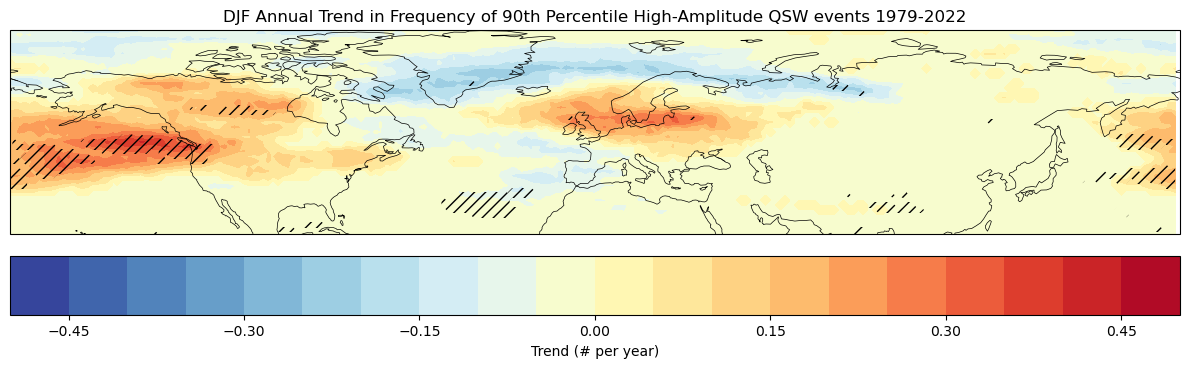

In [36]:
# plot trend map
# lon2d, lat2d = np.meshgrid(amp_90_winter_qsw_yearly.longitude, amp_90_winter_qsw_yearly.latitude)

# fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# c = ax.contourf(lon2d, lat2d, trends,
#                 levels=np.linspace(-0.5, 0.5, 21),
#                 cmap='RdYlBu_r',
#                 transform=ccrs.PlateCarree())
# ax.set_title("DJF Annual Trend in Number of 90th Percentile High-Amplitude QSW events 1979-2022")
# ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())

# cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
# cbar.set_label("Trend (change in # per year)")

# p_value = "p-value = " + str(round(grid_trend.pvalue, 3))
# text_kwargs = dict(fontsize=12, color="red")
# ax.text(0.87, -0.7, p_value, transform=ax.transAxes, **text_kwargs)

# plt.tight_layout()
# plt.show()

# plot mann kendall trend
lon2d, lat2d = np.meshgrid(amp_90_winter_qsw_yearly.longitude, amp_90_winter_qsw_yearly.latitude)
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(slope.longitude,
                slope.latitude,
                slope.q,
                levels=np.linspace(-0.5, 0.5, 21),
                cmap="RdYlBu_r",
                transform=ccrs.PlateCarree())
ax.set_title("DJF Annual Trend in Frequency of 90th Percentile High-Amplitude QSW events 1979-2022")
ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend (# per year)")

# mask p < 0.05 with hatching
sig_mask = (pval["q"] < 0.05)
ax.contourf(lon2d, lat2d, sig_mask, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

### 75th percentile

In [37]:
# first, filter dataset to obtain 75th percentile high-amplitude QSWs
# mask values as 1s and 0s (high-amplitude and not high-amplitude)
winter_quantile_75 = winter_qsw.quantile(q=0.75)["q"].item()
amp_75_winter_qsw = winter_qsw.copy()
amp_75_winter_qsw["q"] = (winter_qsw["q"] > winter_quantile_75).astype(int)
amp_75_winter_qsw

<xarray.Dataset> Size: 386MB
Dimensions:    (time: 4675, latitude: 43, longitude: 240)
Coordinates:
  * time       (time) datetime64[ns] 37kB 1979-01-08 1979-01-09 ... 2022-12-24
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
    dayofyear  (time) int64 37kB ...
Data variables:
    q          (time, latitude, longitude) int64 386MB 1 1 1 1 1 1 ... 0 0 0 0 0

In [38]:
# group data by year
# amp_75_winter_qsw_yearly = amp_75_winter_qsw.groupby("time.year").mean(dim='time', skipna=True)
amp_75_winter_qsw_yearly = amp_75_winter_qsw.groupby("time.year").sum()
amp_75_winter_qsw_yearly

<xarray.Dataset> Size: 4MB
Dimensions:    (year: 44, latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
  * year       (year) int64 352B 1979 1980 1981 1982 ... 2019 2020 2021 2022
Data variables:
    q          (year, latitude, longitude) int64 4MB 34 34 34 34 33 ... 0 0 0 0

In [39]:
# initialize trends array
# trends = np.full((amp_75_winter_qsw_yearly.latitude.shape[0], amp_75_winter_qsw_yearly.longitude.shape[0]), np.nan)
# years = np.unique(amp_75_winter_qsw_yearly["year"])

# # calculate linear trend at each point
# for x in range(amp_75_winter_qsw_yearly.latitude.shape[0]):
#     for y in range(amp_75_winter_qsw_yearly.longitude.shape[0]):
#         y_vals = amp_75_winter_qsw_yearly["q"][:, x, y].values
#         # linear regression for grid cell
#         grid_trend = linregress(years, y_vals)
#         # add regression value to array of trends
#         trends[x, y] = grid_trend.slope

# trends

slope, pval = xr.apply_ufunc(
    manntrend,
    amp_75_winter_qsw_yearly,
    input_core_dims=[['year']],
    output_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float]
)

slope

<xarray.Dataset> Size: 85kB
Dimensions:    (latitude: 43, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
Data variables:
    q          (latitude, longitude) float64 83kB -0.125 -0.1212 ... 0.0 0.0

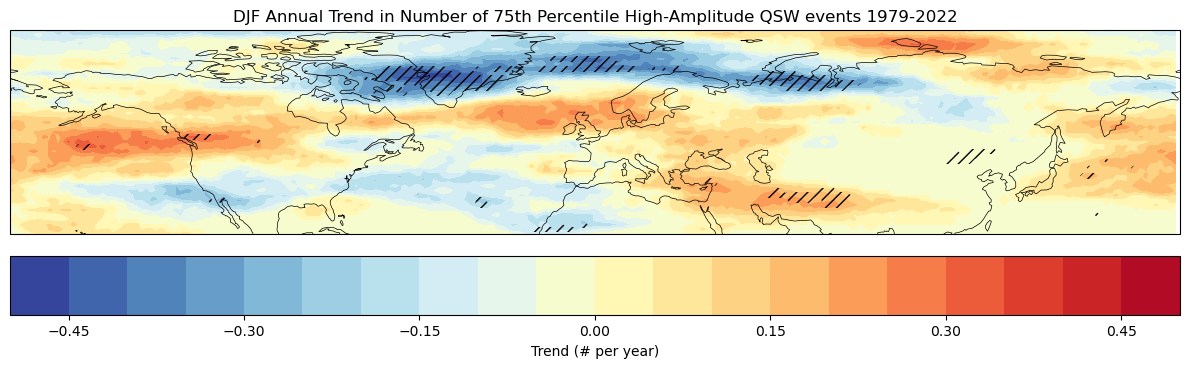

In [40]:
# plot trend map
# lon2d, lat2d = np.meshgrid(amp_90_winter_qsw_yearly.longitude, amp_90_winter_qsw_yearly.latitude)

# fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# c = ax.contourf(lon2d, lat2d, trends,
#                 levels=np.linspace(-0.5, 0.5, 21),
#                 cmap='RdYlBu_r',
#                 transform=ccrs.PlateCarree())
# ax.set_title("DJF Annual Trend in Number of 75th Percentile High-Amplitude QSW events 1979-2022")
# ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())

# cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
# cbar.set_label("Trend (change in # per year)")

# p_value = "p-value = " + str(round(grid_trend.pvalue, 3))
# text_kwargs = dict(fontsize=12, color="red")
# ax.text(0.87, -0.7, p_value, transform=ax.transAxes, **text_kwargs)

# plt.tight_layout()
# plt.show()

# plot mann kendall trend
lon2d, lat2d = np.meshgrid(amp_90_winter_qsw_yearly.longitude, amp_90_winter_qsw_yearly.latitude)
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(slope.longitude,
                slope.latitude,
                slope.q,
                levels=np.linspace(-0.5, 0.5, 21),
                cmap="RdYlBu_r",
                transform=ccrs.PlateCarree())
ax.set_title("DJF Annual Trend in Number of 75th Percentile High-Amplitude QSW events 1979-2022")
ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend (# per year)")

# mask p < 0.05 with hatching
sig_mask = (pval["q"] < 0.05)
ax.contourf(lon2d, lat2d, sig_mask, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

# Annual Mann-Kendall trend map of DJF *high-amplitude persistent* QSWs 1979-2022

## By length of persistence

### 90th percentile

In [6]:
# first, filter dataset to obtain 90th percentile high-amplitude QSWs
# mask values as 1s and 0s (high-amplitude and not high-amplitude)
winter_quantile_90 = winter_qsw.quantile(q=0.9)["q"].item()
amp_90_winter_qsw = winter_qsw.copy()
amp_90_winter_qsw["q"] = (winter_qsw["q"] > winter_quantile_90).astype(int)
amp_90_winter_qsw

<xarray.Dataset> Size: 386MB
Dimensions:    (time: 4675, latitude: 43, longitude: 240)
Coordinates:
  * time       (time) datetime64[ns] 37kB 1979-01-08 1979-01-09 ... 2022-12-24
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
    dayofyear  (time) int64 37kB ...
Data variables:
    q          (time, latitude, longitude) int64 386MB 1 1 1 1 1 1 ... 0 0 0 0 0

In [7]:
N = 5  # minimum persistence length
amps = amp_90_winter_qsw["q"]  # (time, lat, lon)

#### By mean length

In [8]:
# generate keys of all combos of (year, lat, lon)
keys = np.empty((np.unique(amps.time.dt.year).size, amps.shape[1], amps.shape[2]), dtype='object')

for i, lon in enumerate(amps.longitude):
    for j, lat in enumerate(amps.latitude):
        for k, t in enumerate(np.unique(amps.time.dt.year)):
            keys[k, j, i] = (t.item(), lat.item(), lon.item())

keys

array([[[(1979, 84.0, -180.0), (1979, 84.0, -178.5),
         (1979, 84.0, -177.0), ..., (1979, 84.0, 175.5),
         (1979, 84.0, 177.0), (1979, 84.0, 178.5)],
        [(1979, 82.5, -180.0), (1979, 82.5, -178.5),
         (1979, 82.5, -177.0), ..., (1979, 82.5, 175.5),
         (1979, 82.5, 177.0), (1979, 82.5, 178.5)],
        [(1979, 81.0, -180.0), (1979, 81.0, -178.5),
         (1979, 81.0, -177.0), ..., (1979, 81.0, 175.5),
         (1979, 81.0, 177.0), (1979, 81.0, 178.5)],
        ...,
        [(1979, 24.0, -180.0), (1979, 24.0, -178.5),
         (1979, 24.0, -177.0), ..., (1979, 24.0, 175.5),
         (1979, 24.0, 177.0), (1979, 24.0, 178.5)],
        [(1979, 22.5, -180.0), (1979, 22.5, -178.5),
         (1979, 22.5, -177.0), ..., (1979, 22.5, 175.5),
         (1979, 22.5, 177.0), (1979, 22.5, 178.5)],
        [(1979, 21.0, -180.0), (1979, 21.0, -178.5),
         (1979, 21.0, -177.0), ..., (1979, 21.0, 175.5),
         (1979, 21.0, 177.0), (1979, 21.0, 178.5)]],

       [[(198

In [9]:
# flatten keys and create dictionary
persistent_lengths_90 = {key: [] for key in keys.flat}
persistent_lengths_90

{(1979, 84.0, -180.0): [],
 (1979, 84.0, -178.5): [],
 (1979, 84.0, -177.0): [],
 (1979, 84.0, -175.5): [],
 (1979, 84.0, -174.0): [],
 (1979, 84.0, -172.5): [],
 (1979, 84.0, -171.0): [],
 (1979, 84.0, -169.5): [],
 (1979, 84.0, -168.0): [],
 (1979, 84.0, -166.5): [],
 (1979, 84.0, -165.0): [],
 (1979, 84.0, -163.5): [],
 (1979, 84.0, -162.0): [],
 (1979, 84.0, -160.5): [],
 (1979, 84.0, -159.0): [],
 (1979, 84.0, -157.5): [],
 (1979, 84.0, -156.0): [],
 (1979, 84.0, -154.5): [],
 (1979, 84.0, -153.0): [],
 (1979, 84.0, -151.5): [],
 (1979, 84.0, -150.0): [],
 (1979, 84.0, -148.5): [],
 (1979, 84.0, -147.0): [],
 (1979, 84.0, -145.5): [],
 (1979, 84.0, -144.0): [],
 (1979, 84.0, -142.5): [],
 (1979, 84.0, -141.0): [],
 (1979, 84.0, -139.5): [],
 (1979, 84.0, -138.0): [],
 (1979, 84.0, -136.5): [],
 (1979, 84.0, -135.0): [],
 (1979, 84.0, -133.5): [],
 (1979, 84.0, -132.0): [],
 (1979, 84.0, -130.5): [],
 (1979, 84.0, -129.0): [],
 (1979, 84.0, -127.5): [],
 (1979, 84.0, -126.0): [],
 

In [10]:
times = amps.time
years = np.array([t.dt.year.item() for t in times])
lats = amps.latitude.values
lons = amps.longitude.values

for lat_idx, lat in enumerate(lats):
    for lon_idx, lon in enumerate(lons):
        current_len = 0
        current_year = years[0]

        for t in range(len(times)):
            val = amps.values[t, lat_idx, lon_idx]
            year = years[t]

            if val == 1:
                current_len += 1
            else:
                if current_len >= N:
                    key = (current_year, lat, lon)
                    persistent_lengths_90[key].append(current_len)
                current_len = 0

            # update year tracking
            current_year = year

        # Final check if ends with persistent streak
        if current_len >= N:
            key = (year, lat, lon)
            persistent_lengths_90[key].append(current_len)

persistent_lengths_90

{(1979, 84.0, -180.0): [9],
 (1979, 84.0, -178.5): [9, 5],
 (1979, 84.0, -177.0): [9, 5],
 (1979, 84.0, -175.5): [9, 5],
 (1979, 84.0, -174.0): [9, 5],
 (1979, 84.0, -172.5): [9, 5],
 (1979, 84.0, -171.0): [9, 5],
 (1979, 84.0, -169.5): [9, 5],
 (1979, 84.0, -168.0): [9, 5],
 (1979, 84.0, -166.5): [9, 5],
 (1979, 84.0, -165.0): [9, 5],
 (1979, 84.0, -163.5): [9, 5],
 (1979, 84.0, -162.0): [9, 5],
 (1979, 84.0, -160.5): [9, 5],
 (1979, 84.0, -159.0): [9, 5],
 (1979, 84.0, -157.5): [9, 5],
 (1979, 84.0, -156.0): [9, 5],
 (1979, 84.0, -154.5): [9, 5],
 (1979, 84.0, -153.0): [9, 5],
 (1979, 84.0, -151.5): [9, 5],
 (1979, 84.0, -150.0): [9, 5],
 (1979, 84.0, -148.5): [9, 5],
 (1979, 84.0, -147.0): [9, 5],
 (1979, 84.0, -145.5): [9, 5],
 (1979, 84.0, -144.0): [9, 5],
 (1979, 84.0, -142.5): [9, 5],
 (1979, 84.0, -141.0): [9, 5],
 (1979, 84.0, -139.5): [9, 5],
 (1979, 84.0, -138.0): [9, 5],
 (1979, 84.0, -136.5): [9, 5],
 (1979, 84.0, -135.0): [9, 5],
 (1979, 84.0, -133.5): [9, 5],
 (1979, 84.

In [11]:
persistent_avg_lengths_90 = persistent_lengths_90.copy()
for k, v in persistent_avg_lengths_90.items():
    persistent_avg_lengths_90[k] = np.mean(persistent_avg_lengths_90[k]).item()

persistent_avg_lengths_90

/home/nedroos/.conda/envs/nazenv_py.3.13.4/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nedroos/.conda/envs/nazenv_py.3.13.4/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{(1979, 84.0, -180.0): 9.0,
 (1979, 84.0, -178.5): 7.0,
 (1979, 84.0, -177.0): 7.0,
 (1979, 84.0, -175.5): 7.0,
 (1979, 84.0, -174.0): 7.0,
 (1979, 84.0, -172.5): 7.0,
 (1979, 84.0, -171.0): 7.0,
 (1979, 84.0, -169.5): 7.0,
 (1979, 84.0, -168.0): 7.0,
 (1979, 84.0, -166.5): 7.0,
 (1979, 84.0, -165.0): 7.0,
 (1979, 84.0, -163.5): 7.0,
 (1979, 84.0, -162.0): 7.0,
 (1979, 84.0, -160.5): 7.0,
 (1979, 84.0, -159.0): 7.0,
 (1979, 84.0, -157.5): 7.0,
 (1979, 84.0, -156.0): 7.0,
 (1979, 84.0, -154.5): 7.0,
 (1979, 84.0, -153.0): 7.0,
 (1979, 84.0, -151.5): 7.0,
 (1979, 84.0, -150.0): 7.0,
 (1979, 84.0, -148.5): 7.0,
 (1979, 84.0, -147.0): 7.0,
 (1979, 84.0, -145.5): 7.0,
 (1979, 84.0, -144.0): 7.0,
 (1979, 84.0, -142.5): 7.0,
 (1979, 84.0, -141.0): 7.0,
 (1979, 84.0, -139.5): 7.0,
 (1979, 84.0, -138.0): 7.0,
 (1979, 84.0, -136.5): 7.0,
 (1979, 84.0, -135.0): 7.0,
 (1979, 84.0, -133.5): 7.0,
 (1979, 84.0, -132.0): 7.0,
 (1979, 84.0, -130.5): 7.0,
 (1979, 84.0, -129.0): 7.0,
 (1979, 84.0, -127.5

In [12]:
# calculate trend from dictionary
# regroup data by just (lat, lon)
grouped = defaultdict(list)

for (year, lat, lon), val in persistent_avg_lengths_90.items():
    grouped[(lat, lon)].append((year, val))

# grouped.items()
# compute trend per (lat, lon)
trends = {}
pvals = {}

for (lat, lon), year_val_pairs in grouped.items():
    filtered = [(y, v) for y, v in year_val_pairs if not np.isnan(v)]  # remove nans
    # skip if less than 2 valid points
    if len(filtered) < 2:
        trends[(lat, lon)] = np.nan
        continue

    _, values = zip(*sorted(filtered)) # order years + unzip a list of (year, value) pairs into two separate tuples

    slope, pval = manntrend(values)
    trends[(lat, lon)] = slope
    pvals[(lat, lon)] = pval

trends

{(84.0, -180.0): np.float64(0.0),
 (84.0, -178.5): np.float64(0.0),
 (84.0, -177.0): np.float64(0.0),
 (84.0, -175.5): np.float64(0.0),
 (84.0, -174.0): np.float64(-0.014285714285714285),
 (84.0, -172.5): np.float64(-0.013888888888888888),
 (84.0, -171.0): np.float64(-0.014285714285714285),
 (84.0, -169.5): np.float64(-0.014285714285714285),
 (84.0, -168.0): np.float64(-0.015151515151515178),
 (84.0, -166.5): np.float64(-0.020833333333333332),
 (84.0, -165.0): np.float64(-0.02224694104560624),
 (84.0, -163.5): np.float64(-0.020833333333333294),
 (84.0, -162.0): np.float64(-0.021169354838709686),
 (84.0, -160.5): np.float64(-0.03125),
 (84.0, -159.0): np.float64(-0.027777777777777776),
 (84.0, -157.5): np.float64(-0.03508771929824563),
 (84.0, -156.0): np.float64(-0.03571428571428571),
 (84.0, -154.5): np.float64(-0.034482758620689655),
 (84.0, -153.0): np.float64(-0.03125),
 (84.0, -151.5): np.float64(-0.03174603174603176),
 (84.0, -150.0): np.float64(-0.039215686274509824),
 (84.0, -1

In [13]:
# separate lats and lons
lats = sorted(set(k[0] for k in trends))
lons = sorted(set(k[1] for k in trends))
lon2d_p, lat2d_p = np.meshgrid(lons, lats)

# create empty 2D array and fill it
trend3 = np.full((len(lats), len(lons)), np.nan)
pval3 = np.full((len(lats), len(lons)), np.nan)

for (lat, lon), value in trends.items():
    i = lats.index(lat)
    j = lons.index(lon)
    trend3[i, j] = value
    pval3[i, j] = pvals.get((lat, lon), np.nan)

trend3

array([[ 0.5       ,  0.25      ,  1.        , ...,  0.        ,
        -0.5       ,  0.5       ],
       [ 1.25      ,  1.41666667,  1.41666667, ...,  0.        ,
         0.91666667,  1.08333333],
       [ 0.33333333,  0.66666667,  0.66666667, ...,  1.25      ,
         0.5       ,  0.33333333],
       ...,
       [ 0.        , -0.01075269, -0.01075269, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02247475, -0.02301587, -0.00362319, ...,  0.        ,
         0.        , -0.01634769],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.00980392,  0.        ]], shape=(43, 240))

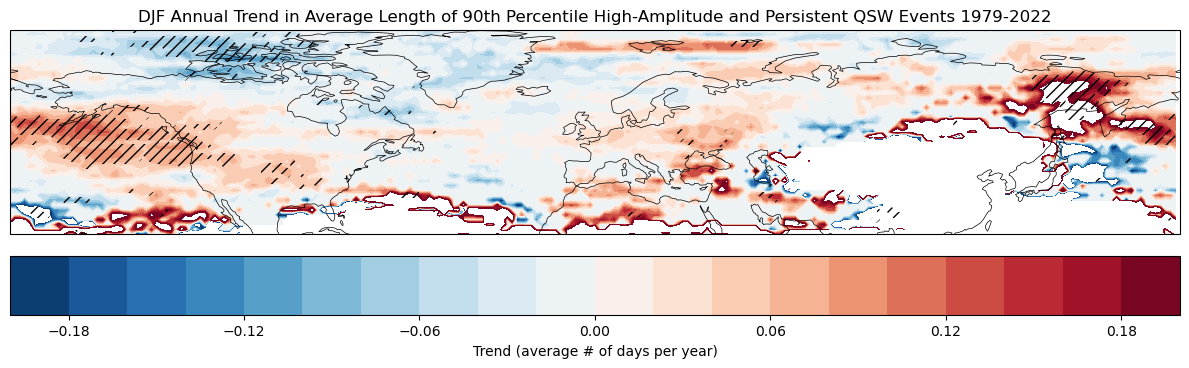

In [14]:
# plotting trend map
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(lon2d_p, lat2d_p, trend3,
                levels=np.linspace(-0.2, 0.2, 21),
                cmap='RdBu_r',
                transform=ccrs.PlateCarree())
ax.set_title("DJF Annual Trend in Average Length of 90th Percentile High-Amplitude and Persistent QSW Events 1979-2022")
ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

# mask p < 0.05 with hatching
sig_mask = (pval3 < 0.05)
ax.contourf(lon2d_p, lat2d_p, sig_mask, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend (average # of days per year)")

plt.tight_layout()
plt.show()

#### By total length

In [31]:
times = amps.time
years = np.array([t.dt.year.item() for t in times])
unique_years = np.arange(1979, 2023)
n_years = len(unique_years)
n_lat = amps.latitude.size
n_lon = amps.longitude.size

# Store total length of persistent events per year per grid cell
persistent_tot_lengths_90 = np.zeros((n_years, n_lat, n_lon), dtype=int)

for lat_idx in range(n_lat):
    for lon_idx in range(n_lon):
        current_len = 0
        for t in range(len(amps.time.values)):
            val = amps.values[t, lat_idx, lon_idx]
            year_idx = years[t] - 1979
            
            if val == 1:
                current_len += 1
            else:
                if current_len >= N:
                    persistent_tot_lengths_90[year_idx, lat_idx, lon_idx] += current_len
                current_len = 0

        # Handle if time series ends with a persistent streak
        if current_len >= N:
            year_idx = years[-1] - 1979
            persistent_tot_lengths_90[year_idx, lat_idx, lon_idx] += current_len

persistent_tot_lengths_90

array([[[ 9, 14, 14, ...,  9,  9,  9],
        [15, 15, 15, ..., 13, 13, 14],
        [17, 18, 18, ..., 16, 16, 16],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[13, 13, 13, ..., 18, 13, 13],
        [10, 11, 12, ..., 10, 10, 10],
        [19, 19, 19, ..., 18, 19, 19],
        ...,
        [ 0,  0,  0, ...,  5,  5,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[14, 14, 14, ..., 13, 13, 13],
        [14, 14, 14, ..., 13, 14, 14],
        [15, 15, 15, ..., 13, 14, 14],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       ...,

       [[14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14],
        [12, 12, 12, ..., 12, 12, 12],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0

In [32]:
persistent_ds = xr.DataArray(
    persistent_tot_lengths_90,
    dims=["year", "latitude", "longitude"],
    coords={
        "year": unique_years,
        "latitude": amps.latitude.values,
        "longitude": amps.longitude.values
    },
    name="persistent_total_length"
).to_dataset()
persistent_ds

<xarray.Dataset> Size: 4MB
Dimensions:                  (year: 44, latitude: 43, longitude: 240)
Coordinates:
  * year                     (year) int64 352B 1979 1980 1981 ... 2020 2021 2022
  * latitude                 (latitude) float64 344B 84.0 82.5 ... 22.5 21.0
  * longitude                (longitude) float64 2kB -180.0 -178.5 ... 178.5
Data variables:
    persistent_total_length  (year, latitude, longitude) int64 4MB 9 14 ... 0 0

In [33]:
# initialize trends array
# trends = np.full((persistent_ds.latitude.shape[0], persistent_ds.longitude.shape[0]), np.nan)
# years = np.unique(persistent_ds["year"])

# # calculate linear trend at each point
# for x in range(persistent_ds.latitude.shape[0]):
#     for y in range(persistent_ds.longitude.shape[0]):
#         y_vals = persistent_ds["persistent_total_length"][:, x, y].values
#         # linear regression for grid cell
#         grid_trend = linregress(years, y_vals)
#         # add regression value to array of trends
#         trends[x, y] = grid_trend.slope

# trends

slope, pval = xr.apply_ufunc(
    manntrend,
    persistent_ds,
    input_core_dims=[['year']],
    output_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float]
)

slope

<xarray.Dataset> Size: 85kB
Dimensions:                  (latitude: 43, longitude: 240)
Coordinates:
  * latitude                 (latitude) float64 344B 84.0 82.5 ... 22.5 21.0
  * longitude                (longitude) float64 2kB -180.0 -178.5 ... 178.5
Data variables:
    persistent_total_length  (latitude, longitude) float64 83kB -0.0125 ... 0.0

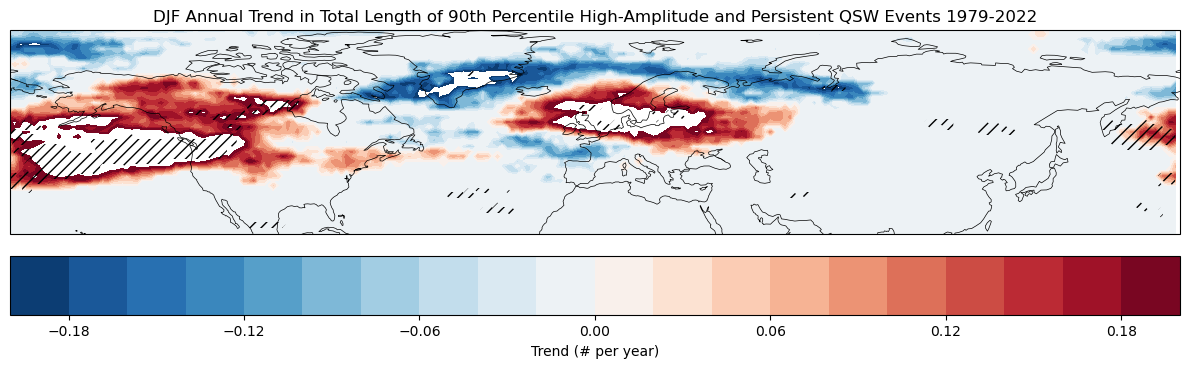

In [34]:
# plot trend map
# lon2d, lat2d = np.meshgrid(persistent_ds.longitude, persistent_ds.latitude)

# fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# c = ax.contourf(lon2d, lat2d, trends,
#                 levels=np.linspace(-0.5, 0.5, 21),
#                 cmap='RdYlBu_r',
#                 transform=ccrs.PlateCarree())
# ax.set_title("DJF Annual Trend in Total Length of 90th Percentile High-Amplitude and Persistent QSW Events 1979-2022")
# ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())

# cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
# cbar.set_label("Trend (length per year)")

# p_value = "p-value = " + str(round(grid_trend.pvalue, 3))
# text_kwargs = dict(fontsize=12, color="red")
# ax.text(0.87, -0.7, p_value, transform=ax.transAxes, **text_kwargs)

# plt.tight_layout()
# plt.show()

# plot mann kendall trend
lon2d, lat2d = np.meshgrid(persistent_ds.longitude, persistent_ds.latitude)
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(slope.longitude,
                slope.latitude,
                slope.persistent_total_length,
                levels=np.linspace(-0.2, 0.2, 21),
                cmap="RdBu_r",
                transform=ccrs.PlateCarree())
ax.set_title("DJF Annual Trend in Total Length of 90th Percentile High-Amplitude and Persistent QSW Events 1979-2022")
ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend (# per year)")

# mask p < 0.05 with hatching
sig_mask = (pval["persistent_total_length"] < 0.05)
ax.contourf(lon2d, lat2d, sig_mask, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

### 75th percentile (IGNORE)

In [17]:
# first, filter dataset to obtain 75th percentile high-amplitude QSWs
# mask values as 1s and 0s (high-amplitude and not high-amplitude)
winter_quantile_75 = winter_qsw.quantile(q=0.75)["q"].item()
amp_75_winter_qsw = winter_qsw.copy()
amp_75_winter_qsw["q"] = (winter_qsw["q"] > winter_quantile_75).astype(int)
amp_75_winter_qsw

<xarray.Dataset> Size: 386MB
Dimensions:    (time: 4675, latitude: 43, longitude: 240)
Coordinates:
  * time       (time) datetime64[ns] 37kB 1979-01-08 1979-01-09 ... 2022-12-24
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
    dayofyear  (time) int64 37kB ...
Data variables:
    q          (time, latitude, longitude) int64 386MB 1 1 1 1 1 1 ... 0 0 0 0 0

In [18]:
N = 5  # minimum persistence length
amps = amp_75_winter_qsw["q"]  # (time, lat, lon)

#### By mean length

In [19]:
# generate keys of all combos of (year, lat, lon)
keys = np.empty((np.unique(amps.time.dt.year).size, amps.shape[1], amps.shape[2]), dtype='object')

for i, lon in enumerate(amps.longitude):
    for j, lat in enumerate(amps.latitude):
        for k, t in enumerate(np.unique(amps.time.dt.year)):
            keys[k, j, i] = (t.item(), lat.item(), lon.item())

keys

array([[[(1979, 84.0, -180.0), (1979, 84.0, -178.5),
         (1979, 84.0, -177.0), ..., (1979, 84.0, 175.5),
         (1979, 84.0, 177.0), (1979, 84.0, 178.5)],
        [(1979, 82.5, -180.0), (1979, 82.5, -178.5),
         (1979, 82.5, -177.0), ..., (1979, 82.5, 175.5),
         (1979, 82.5, 177.0), (1979, 82.5, 178.5)],
        [(1979, 81.0, -180.0), (1979, 81.0, -178.5),
         (1979, 81.0, -177.0), ..., (1979, 81.0, 175.5),
         (1979, 81.0, 177.0), (1979, 81.0, 178.5)],
        ...,
        [(1979, 24.0, -180.0), (1979, 24.0, -178.5),
         (1979, 24.0, -177.0), ..., (1979, 24.0, 175.5),
         (1979, 24.0, 177.0), (1979, 24.0, 178.5)],
        [(1979, 22.5, -180.0), (1979, 22.5, -178.5),
         (1979, 22.5, -177.0), ..., (1979, 22.5, 175.5),
         (1979, 22.5, 177.0), (1979, 22.5, 178.5)],
        [(1979, 21.0, -180.0), (1979, 21.0, -178.5),
         (1979, 21.0, -177.0), ..., (1979, 21.0, 175.5),
         (1979, 21.0, 177.0), (1979, 21.0, 178.5)]],

       [[(198

In [20]:
# flatten keys and create dictionary
persistent_lengths_75 = {key: [] for key in keys.flat}
persistent_lengths_75

{(1979, 84.0, -180.0): [],
 (1979, 84.0, -178.5): [],
 (1979, 84.0, -177.0): [],
 (1979, 84.0, -175.5): [],
 (1979, 84.0, -174.0): [],
 (1979, 84.0, -172.5): [],
 (1979, 84.0, -171.0): [],
 (1979, 84.0, -169.5): [],
 (1979, 84.0, -168.0): [],
 (1979, 84.0, -166.5): [],
 (1979, 84.0, -165.0): [],
 (1979, 84.0, -163.5): [],
 (1979, 84.0, -162.0): [],
 (1979, 84.0, -160.5): [],
 (1979, 84.0, -159.0): [],
 (1979, 84.0, -157.5): [],
 (1979, 84.0, -156.0): [],
 (1979, 84.0, -154.5): [],
 (1979, 84.0, -153.0): [],
 (1979, 84.0, -151.5): [],
 (1979, 84.0, -150.0): [],
 (1979, 84.0, -148.5): [],
 (1979, 84.0, -147.0): [],
 (1979, 84.0, -145.5): [],
 (1979, 84.0, -144.0): [],
 (1979, 84.0, -142.5): [],
 (1979, 84.0, -141.0): [],
 (1979, 84.0, -139.5): [],
 (1979, 84.0, -138.0): [],
 (1979, 84.0, -136.5): [],
 (1979, 84.0, -135.0): [],
 (1979, 84.0, -133.5): [],
 (1979, 84.0, -132.0): [],
 (1979, 84.0, -130.5): [],
 (1979, 84.0, -129.0): [],
 (1979, 84.0, -127.5): [],
 (1979, 84.0, -126.0): [],
 

In [21]:
times = amps.time
years = np.array([t.dt.year.item() for t in times])
lats = amps.latitude.values
lons = amps.longitude.values

for lat_idx, lat in enumerate(lats):
    for lon_idx, lon in enumerate(lons):
        current_len = 0
        current_year = years[0]

        for t in range(len(times)):
            val = amps.values[t, lat_idx, lon_idx]
            year = years[t]

            if val == 1:
                current_len += 1
            else:
                if current_len >= N:
                    key = (current_year, lat, lon)
                    persistent_lengths_75[key].append(current_len)
                current_len = 0

            # update year tracking
            current_year = year

        # Final check if ends with persistent streak
        if current_len >= N:
            key = (year, lat, lon)
            persistent_lengths_75[key].append(current_len)

persistent_lengths_75

{(1979, 84.0, -180.0): [11, 6, 15],
 (1979, 84.0, -178.5): [11, 6, 15],
 (1979, 84.0, -177.0): [11, 6, 15],
 (1979, 84.0, -175.5): [11, 6, 15],
 (1979, 84.0, -174.0): [11, 6, 15],
 (1979, 84.0, -172.5): [11, 6, 15],
 (1979, 84.0, -171.0): [11, 6, 15],
 (1979, 84.0, -169.5): [11, 6, 15],
 (1979, 84.0, -168.0): [11, 6, 15],
 (1979, 84.0, -166.5): [11, 6, 15],
 (1979, 84.0, -165.0): [11, 6, 15],
 (1979, 84.0, -163.5): [11, 6, 15],
 (1979, 84.0, -162.0): [11, 6, 15],
 (1979, 84.0, -160.5): [11, 6, 15],
 (1979, 84.0, -159.0): [11, 6, 15],
 (1979, 84.0, -157.5): [11, 6, 14],
 (1979, 84.0, -156.0): [11, 6, 14],
 (1979, 84.0, -154.5): [11, 5, 14],
 (1979, 84.0, -153.0): [11, 5, 14],
 (1979, 84.0, -151.5): [11, 5, 14],
 (1979, 84.0, -150.0): [11, 5, 14],
 (1979, 84.0, -148.5): [11, 5, 13],
 (1979, 84.0, -147.0): [11, 5, 12],
 (1979, 84.0, -145.5): [11, 5, 12],
 (1979, 84.0, -144.0): [11, 5, 12],
 (1979, 84.0, -142.5): [11, 5, 11],
 (1979, 84.0, -141.0): [11, 5, 11],
 (1979, 84.0, -139.5): [11, 

In [22]:
persistent_avg_lengths_75 = persistent_lengths_75.copy()
for k, v in persistent_avg_lengths_75.items():
    persistent_avg_lengths_75[k] = np.mean(persistent_avg_lengths_75[k]).item()

persistent_avg_lengths_75

/home/nedroos/.conda/envs/nazenv_py.3.13.4/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nedroos/.conda/envs/nazenv_py.3.13.4/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{(1979, 84.0, -180.0): 10.666666666666666,
 (1979, 84.0, -178.5): 10.666666666666666,
 (1979, 84.0, -177.0): 10.666666666666666,
 (1979, 84.0, -175.5): 10.666666666666666,
 (1979, 84.0, -174.0): 10.666666666666666,
 (1979, 84.0, -172.5): 10.666666666666666,
 (1979, 84.0, -171.0): 10.666666666666666,
 (1979, 84.0, -169.5): 10.666666666666666,
 (1979, 84.0, -168.0): 10.666666666666666,
 (1979, 84.0, -166.5): 10.666666666666666,
 (1979, 84.0, -165.0): 10.666666666666666,
 (1979, 84.0, -163.5): 10.666666666666666,
 (1979, 84.0, -162.0): 10.666666666666666,
 (1979, 84.0, -160.5): 10.666666666666666,
 (1979, 84.0, -159.0): 10.666666666666666,
 (1979, 84.0, -157.5): 10.333333333333334,
 (1979, 84.0, -156.0): 10.333333333333334,
 (1979, 84.0, -154.5): 10.0,
 (1979, 84.0, -153.0): 10.0,
 (1979, 84.0, -151.5): 10.0,
 (1979, 84.0, -150.0): 10.0,
 (1979, 84.0, -148.5): 9.666666666666666,
 (1979, 84.0, -147.0): 9.333333333333334,
 (1979, 84.0, -145.5): 9.333333333333334,
 (1979, 84.0, -144.0): 9.33

In [23]:
# calculate trend from dictionary
# regroup data by just (lat, lon)
grouped = defaultdict(list)

for (year, lat, lon), val in persistent_avg_lengths_75.items():
    grouped[(lat, lon)].append((year, val))

# grouped.items()
# compute trend per (lat, lon)
trends = {}
pvals = {}

for (lat, lon), year_val_pairs in grouped.items():
    filtered = [(y, v) for y, v in year_val_pairs if not np.isnan(v)]  # remove nans
    # skip if less than 2 valid points
    if len(filtered) < 2:
        trends[(lat, lon)] = np.nan
        continue

    _, values = zip(*sorted(filtered)) # order years + unzip a list of (year, value) pairs into two separate tuples

    slope, pval = manntrend(values)
    trends[(lat, lon)] = slope
    pvals[(lat, lon)] = pval

trends

{(84.0, -180.0): np.float64(-0.04326923076923094),
 (84.0, -178.5): np.float64(-0.0409946236559139),
 (84.0, -177.0): np.float64(-0.04233870967741936),
 (84.0, -175.5): np.float64(-0.04449472096530922),
 (84.0, -174.0): np.float64(-0.04587542087542087),
 (84.0, -172.5): np.float64(-0.04587542087542087),
 (84.0, -171.0): np.float64(-0.03985178463399878),
 (84.0, -169.5): np.float64(-0.0365625),
 (84.0, -168.0): np.float64(-0.04099462365591398),
 (84.0, -166.5): np.float64(-0.04411764705882353),
 (84.0, -165.0): np.float64(-0.04229797979797983),
 (84.0, -163.5): np.float64(-0.041666666666666664),
 (84.0, -162.0): np.float64(-0.042261904761904806),
 (84.0, -160.5): np.float64(-0.039531250000000004),
 (84.0, -159.0): np.float64(-0.04166666666666652),
 (84.0, -157.5): np.float64(-0.03883861236802415),
 (84.0, -156.0): np.float64(-0.041666666666666644),
 (84.0, -154.5): np.float64(-0.04083333333333332),
 (84.0, -153.0): np.float64(-0.03333333333333335),
 (84.0, -151.5): np.float64(-0.0337837

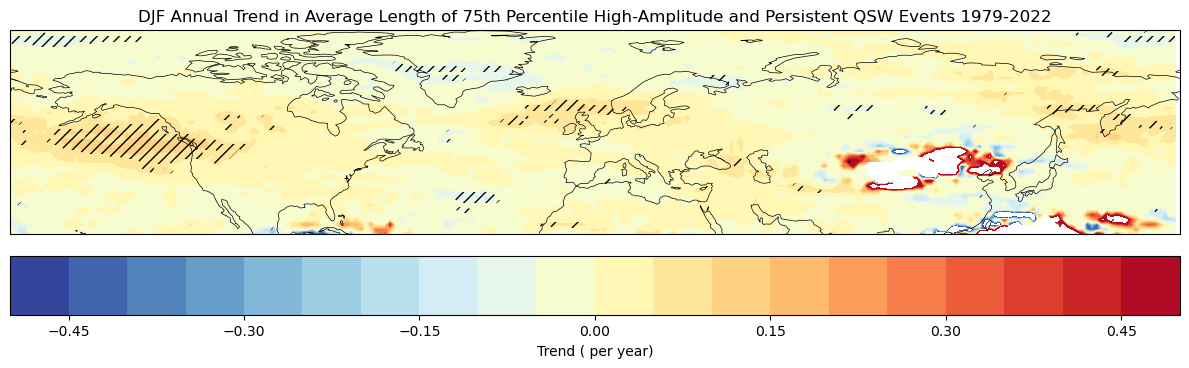

In [24]:
# plotting trend map
# separate lats and lons
lats = sorted(set(k[0] for k in trends))
lons = sorted(set(k[1] for k in trends))

# create empty 2D array and fill it
trend_array = np.full((len(lats), len(lons)), np.nan)
pval_array = np.full((len(lats), len(lons)), np.nan)

for (lat, lon), value in trends.items():
    i = lats.index(lat)
    j = lons.index(lon)
    trend_array[i, j] = value
    pval_array[i, j] = pvals.get((lat, lon), np.nan)

# create lat lon meshgrid
lon2d, lat2d = np.meshgrid(lons, lats)

fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

c = ax.contourf(lon2d, lat2d, trend_array,
                levels=np.linspace(-0.5, 0.5, 21),
                cmap='RdYlBu_r',
                transform=ccrs.PlateCarree())
ax.set_title("DJF Annual Trend in Average Length of 75th Percentile High-Amplitude and Persistent QSW Events 1979-2022")
ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

# mask p < 0.05 with hatching
sig_mask = (pval_array < 0.05)
ax.contourf(lon2d, lat2d, sig_mask, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend ( per year)")

plt.tight_layout()
plt.show()

#### By total length

In [25]:
times = amps.time
years = np.array([t.dt.year.item() for t in times])
unique_years = np.arange(1979, 2023)
n_years = len(unique_years)
n_lat = amps.latitude.size
n_lon = amps.longitude.size

# Store total length of persistent events per year per grid cell
persistent_tot_lengths_75 = np.zeros((n_years, n_lat, n_lon), dtype=int)

for lat_idx in range(n_lat):
    for lon_idx in range(n_lon):
        current_len = 0
        for t in range(len(amps.time.values)):
            val = amps.values[t, lat_idx, lon_idx]
            year_idx = years[t] - 1979
            
            if val == 1:
                current_len += 1
            else:
                if current_len >= N:
                    persistent_tot_lengths_75[year_idx, lat_idx, lon_idx] += current_len
                current_len = 0

        # Handle if time series ends with a persistent streak
        if current_len >= N:
            year_idx = years[-1] - 1979
            persistent_tot_lengths_75[year_idx, lat_idx, lon_idx] += current_len

persistent_tot_lengths_75

array([[[32, 32, 32, ..., 34, 32, 32],
        [34, 34, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 32, 32, 33],
        ...,
        [ 5,  5,  5, ...,  0,  5,  5],
        [ 5,  5,  5, ...,  0,  0,  0],
        [ 5,  6,  6, ...,  5,  5,  5]],

       [[37, 37, 37, ..., 38, 38, 38],
        [32, 32, 33, ..., 33, 33, 33],
        [30, 30, 30, ..., 31, 30, 30],
        ...,
        [ 7,  7,  6, ...,  7,  7,  7],
        [ 7,  6,  6, ...,  7,  7,  7],
        [ 6,  6,  5, ...,  6,  6,  6]],

       [[32, 32, 32, ..., 32, 32, 32],
        [37, 37, 37, ..., 32, 37, 37],
        [42, 42, 42, ..., 41, 41, 41],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       ...,

       [[22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 23, 22, 22],
        [23, 23, 22, ..., 22, 23, 23],
        ...,
        [ 5,  5,  5, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0

In [26]:
persistent_ds = xr.DataArray(
    persistent_tot_lengths_75,
    dims=["year", "latitude", "longitude"],
    coords={
        "year": unique_years,
        "latitude": amps.latitude.values,
        "longitude": amps.longitude.values
    },
    name="persistent_total_length"
).to_dataset()
persistent_ds

<xarray.Dataset> Size: 4MB
Dimensions:                  (year: 44, latitude: 43, longitude: 240)
Coordinates:
  * year                     (year) int64 352B 1979 1980 1981 ... 2020 2021 2022
  * latitude                 (latitude) float64 344B 84.0 82.5 ... 22.5 21.0
  * longitude                (longitude) float64 2kB -180.0 -178.5 ... 178.5
Data variables:
    persistent_total_length  (year, latitude, longitude) int64 4MB 32 32 ... 0 0

In [27]:
# initialize trends array
# trends = np.full((persistent_ds.latitude.shape[0], persistent_ds.longitude.shape[0]), np.nan)
# years = np.unique(persistent_ds["year"])

# # calculate linear trend at each point
# for x in range(persistent_ds.latitude.shape[0]):
#     for y in range(persistent_ds.longitude.shape[0]):
#         y_vals = persistent_ds["persistent_total_length"][:, x, y].values
#         # linear regression for grid cell
#         grid_trend = linregress(years, y_vals)
#         # add regression value to array of trends
#         trends[x, y] = grid_trend.slope

# trends

slope, pval = xr.apply_ufunc(
    manntrend,
    persistent_ds,
    input_core_dims=[['year']],
    output_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float]
)

slope

<xarray.Dataset> Size: 85kB
Dimensions:                  (latitude: 43, longitude: 240)
Coordinates:
  * latitude                 (latitude) float64 344B 84.0 82.5 ... 22.5 21.0
  * longitude                (longitude) float64 2kB -180.0 -178.5 ... 178.5
Data variables:
    persistent_total_length  (latitude, longitude) float64 83kB -0.1515 ... 0.0

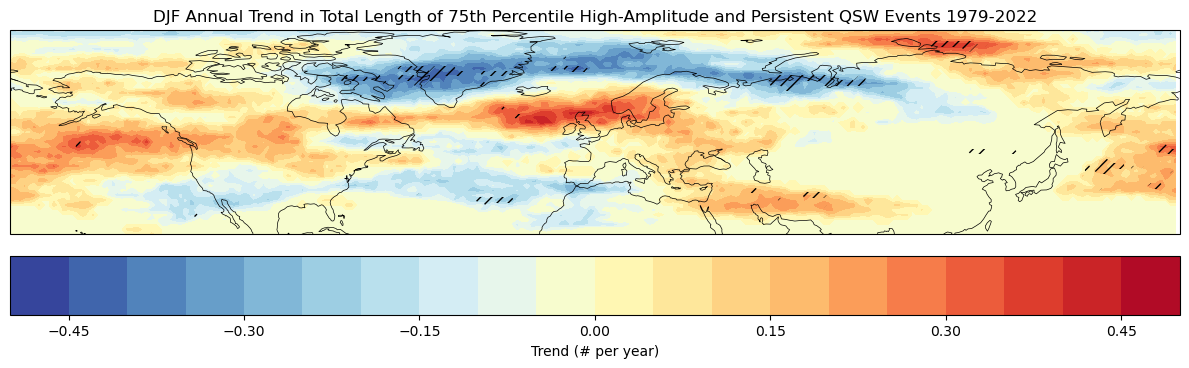

In [28]:
# plot trend map
# lon2d, lat2d = np.meshgrid(persistent_ds.longitude, persistent_ds.latitude)

# fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# c = ax.contourf(lon2d, lat2d, trends,
#                 levels=np.linspace(-0.5, 0.5, 21),
#                 cmap='RdYlBu_r',
#                 transform=ccrs.PlateCarree())
# ax.set_title("DJF Annual Trend in Total Length of 90th Percentile High-Amplitude and Persistent QSW Events 1979-2022")
# ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())

# cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
# cbar.set_label("Trend (length per year)")

# p_value = "p-value = " + str(round(grid_trend.pvalue, 3))
# text_kwargs = dict(fontsize=12, color="red")
# ax.text(0.87, -0.7, p_value, transform=ax.transAxes, **text_kwargs)

# plt.tight_layout()
# plt.show()

# plot mann kendall trend
lon2d, lat2d = np.meshgrid(persistent_ds.longitude, persistent_ds.latitude)
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(slope.longitude,
                slope.latitude,
                slope.persistent_total_length,
                levels=np.linspace(-0.5, 0.5, 21),
                cmap="RdYlBu_r",
                transform=ccrs.PlateCarree())
ax.set_title("DJF Annual Trend in Total Length of 75th Percentile High-Amplitude and Persistent QSW Events 1979-2022")
ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend (# per year)")

# mask p < 0.05 with hatching
sig_mask = (pval["persistent_total_length"] < 0.05)
ax.contourf(lon2d, lat2d, sig_mask, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

## By number of persistent events

### 90th percentile

In [19]:
persistent_lengths_90

{(1979, 84.0, -180.0): [9],
 (1979, 84.0, -178.5): [9, 5],
 (1979, 84.0, -177.0): [9, 5],
 (1979, 84.0, -175.5): [9, 5],
 (1979, 84.0, -174.0): [9, 5],
 (1979, 84.0, -172.5): [9, 5],
 (1979, 84.0, -171.0): [9, 5],
 (1979, 84.0, -169.5): [9, 5],
 (1979, 84.0, -168.0): [9, 5],
 (1979, 84.0, -166.5): [9, 5],
 (1979, 84.0, -165.0): [9, 5],
 (1979, 84.0, -163.5): [9, 5],
 (1979, 84.0, -162.0): [9, 5],
 (1979, 84.0, -160.5): [9, 5],
 (1979, 84.0, -159.0): [9, 5],
 (1979, 84.0, -157.5): [9, 5],
 (1979, 84.0, -156.0): [9, 5],
 (1979, 84.0, -154.5): [9, 5],
 (1979, 84.0, -153.0): [9, 5],
 (1979, 84.0, -151.5): [9, 5],
 (1979, 84.0, -150.0): [9, 5],
 (1979, 84.0, -148.5): [9, 5],
 (1979, 84.0, -147.0): [9, 5],
 (1979, 84.0, -145.5): [9, 5],
 (1979, 84.0, -144.0): [9, 5],
 (1979, 84.0, -142.5): [9, 5],
 (1979, 84.0, -141.0): [9, 5],
 (1979, 84.0, -139.5): [9, 5],
 (1979, 84.0, -138.0): [9, 5],
 (1979, 84.0, -136.5): [9, 5],
 (1979, 84.0, -135.0): [9, 5],
 (1979, 84.0, -133.5): [9, 5],
 (1979, 84.

In [20]:
noofoccurrences = persistent_lengths_90.copy()
for k, v in noofoccurrences.items():
    noofoccurrences[k] = len(noofoccurrences[k])
noofoccurrences

{(1979, 84.0, -180.0): 1,
 (1979, 84.0, -178.5): 2,
 (1979, 84.0, -177.0): 2,
 (1979, 84.0, -175.5): 2,
 (1979, 84.0, -174.0): 2,
 (1979, 84.0, -172.5): 2,
 (1979, 84.0, -171.0): 2,
 (1979, 84.0, -169.5): 2,
 (1979, 84.0, -168.0): 2,
 (1979, 84.0, -166.5): 2,
 (1979, 84.0, -165.0): 2,
 (1979, 84.0, -163.5): 2,
 (1979, 84.0, -162.0): 2,
 (1979, 84.0, -160.5): 2,
 (1979, 84.0, -159.0): 2,
 (1979, 84.0, -157.5): 2,
 (1979, 84.0, -156.0): 2,
 (1979, 84.0, -154.5): 2,
 (1979, 84.0, -153.0): 2,
 (1979, 84.0, -151.5): 2,
 (1979, 84.0, -150.0): 2,
 (1979, 84.0, -148.5): 2,
 (1979, 84.0, -147.0): 2,
 (1979, 84.0, -145.5): 2,
 (1979, 84.0, -144.0): 2,
 (1979, 84.0, -142.5): 2,
 (1979, 84.0, -141.0): 2,
 (1979, 84.0, -139.5): 2,
 (1979, 84.0, -138.0): 2,
 (1979, 84.0, -136.5): 2,
 (1979, 84.0, -135.0): 2,
 (1979, 84.0, -133.5): 2,
 (1979, 84.0, -132.0): 2,
 (1979, 84.0, -130.5): 2,
 (1979, 84.0, -129.0): 2,
 (1979, 84.0, -127.5): 2,
 (1979, 84.0, -126.0): 2,
 (1979, 84.0, -124.5): 2,
 (1979, 84.0

In [21]:
# calculate trend from dictionary
# regroup data by just (lat, lon)
grouped = defaultdict(list)

for (year, lat, lon), val in noofoccurrences.items():
    grouped[(lat, lon)].append((year, val))

# grouped.items()
# compute trend per (lat, lon)
trends = {}
pvals = {}

for (lat, lon), year_val_pairs in grouped.items():
    filtered = [(y, v) for y, v in year_val_pairs if not np.isnan(v)]  # remove nans
    # skip if less than 2 valid points
    if len(filtered) < 2:
        trends[(lat, lon)] = np.nan
        continue

    _, values = zip(*sorted(filtered)) # order years + unzip a list of (year, value) pairs into two separate tuples

    slope, pval = manntrend(values)
    trends[(lat, lon)] = slope
    pvals[(lat, lon)] = pval

trends

{(84.0, -180.0): np.float64(0.0),
 (84.0, -178.5): np.float64(0.0),
 (84.0, -177.0): np.float64(0.0),
 (84.0, -175.5): np.float64(0.0),
 (84.0, -174.0): np.float64(0.0),
 (84.0, -172.5): np.float64(0.0),
 (84.0, -171.0): np.float64(0.0),
 (84.0, -169.5): np.float64(0.0),
 (84.0, -168.0): np.float64(0.0),
 (84.0, -166.5): np.float64(0.0),
 (84.0, -165.0): np.float64(0.0),
 (84.0, -163.5): np.float64(0.0),
 (84.0, -162.0): np.float64(0.0),
 (84.0, -160.5): np.float64(0.0),
 (84.0, -159.0): np.float64(0.0),
 (84.0, -157.5): np.float64(0.0),
 (84.0, -156.0): np.float64(0.0),
 (84.0, -154.5): np.float64(0.0),
 (84.0, -153.0): np.float64(0.0),
 (84.0, -151.5): np.float64(0.0),
 (84.0, -150.0): np.float64(0.0),
 (84.0, -148.5): np.float64(0.0),
 (84.0, -147.0): np.float64(0.0),
 (84.0, -145.5): np.float64(0.0),
 (84.0, -144.0): np.float64(0.0),
 (84.0, -142.5): np.float64(0.0),
 (84.0, -141.0): np.float64(0.0),
 (84.0, -139.5): np.float64(0.0),
 (84.0, -138.0): np.float64(0.0),
 (84.0, -136.5

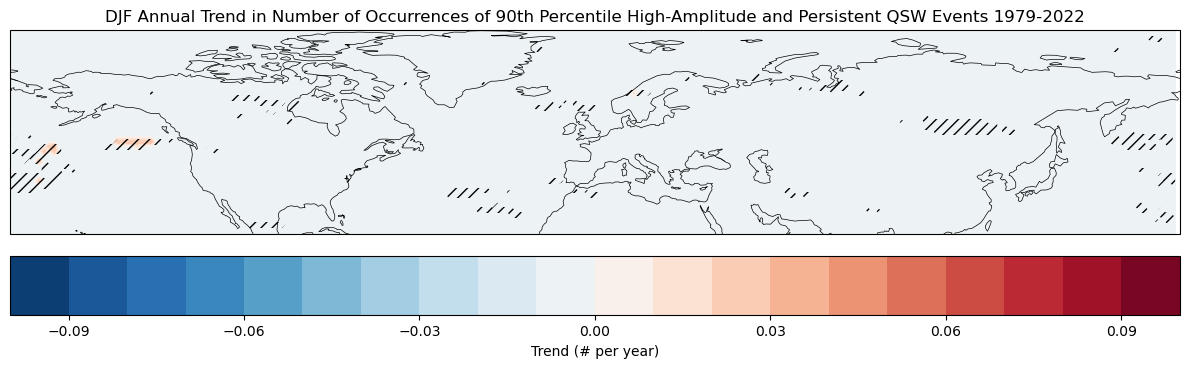

In [23]:
# plotting trend map
# separate lats and lons
lats = sorted(set(k[0] for k in trends))
lons = sorted(set(k[1] for k in trends))

# create empty 2D array and fill it
trend_array = np.full((len(lats), len(lons)), np.nan)
pval_array = np.full((len(lats), len(lons)), np.nan)

for (lat, lon), value in trends.items():
    i = lats.index(lat)
    j = lons.index(lon)
    trend_array[i, j] = value

for (lat, lon), value in pvals.items():
    i = lats.index(lat)
    j = lons.index(lon)
    pval_array[i, j] = value

# create lat lon meshgrid
lon2d, lat2d = np.meshgrid(lons, lats)
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(lon2d, lat2d, trend_array,
                levels=np.linspace(-0.1, 0.1, 21),
                cmap='RdBu_r',
                transform=ccrs.PlateCarree())
ax.set_title("DJF Annual Trend in Number of Occurrences of 90th Percentile High-Amplitude and Persistent QSW Events 1979-2022")
ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend (# per year)")

# mask p < 0.05 with hatching
sig_mask = (pval_array < 0.05)
ax.contourf(lon2d, lat2d, sig_mask, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

### 75th percentile

In [34]:
persistent_lengths_75

{(1979, 84.0, -180.0): [11, 6, 15],
 (1979, 84.0, -178.5): [11, 6, 15],
 (1979, 84.0, -177.0): [11, 6, 15],
 (1979, 84.0, -175.5): [11, 6, 15],
 (1979, 84.0, -174.0): [11, 6, 15],
 (1979, 84.0, -172.5): [11, 6, 15],
 (1979, 84.0, -171.0): [11, 6, 15],
 (1979, 84.0, -169.5): [11, 6, 15],
 (1979, 84.0, -168.0): [11, 6, 15],
 (1979, 84.0, -166.5): [11, 6, 15],
 (1979, 84.0, -165.0): [11, 6, 15],
 (1979, 84.0, -163.5): [11, 6, 15],
 (1979, 84.0, -162.0): [11, 6, 15],
 (1979, 84.0, -160.5): [11, 6, 15],
 (1979, 84.0, -159.0): [11, 6, 15],
 (1979, 84.0, -157.5): [11, 6, 14],
 (1979, 84.0, -156.0): [11, 6, 14],
 (1979, 84.0, -154.5): [11, 5, 14],
 (1979, 84.0, -153.0): [11, 5, 14],
 (1979, 84.0, -151.5): [11, 5, 14],
 (1979, 84.0, -150.0): [11, 5, 14],
 (1979, 84.0, -148.5): [11, 5, 13],
 (1979, 84.0, -147.0): [11, 5, 12],
 (1979, 84.0, -145.5): [11, 5, 12],
 (1979, 84.0, -144.0): [11, 5, 12],
 (1979, 84.0, -142.5): [11, 5, 11],
 (1979, 84.0, -141.0): [11, 5, 11],
 (1979, 84.0, -139.5): [11, 

In [35]:
noofoccurrences = persistent_lengths_75.copy()
for k, v in noofoccurrences.items():
    noofoccurrences[k] = len(noofoccurrences[k])
noofoccurrences

{(1979, 84.0, -180.0): 3,
 (1979, 84.0, -178.5): 3,
 (1979, 84.0, -177.0): 3,
 (1979, 84.0, -175.5): 3,
 (1979, 84.0, -174.0): 3,
 (1979, 84.0, -172.5): 3,
 (1979, 84.0, -171.0): 3,
 (1979, 84.0, -169.5): 3,
 (1979, 84.0, -168.0): 3,
 (1979, 84.0, -166.5): 3,
 (1979, 84.0, -165.0): 3,
 (1979, 84.0, -163.5): 3,
 (1979, 84.0, -162.0): 3,
 (1979, 84.0, -160.5): 3,
 (1979, 84.0, -159.0): 3,
 (1979, 84.0, -157.5): 3,
 (1979, 84.0, -156.0): 3,
 (1979, 84.0, -154.5): 3,
 (1979, 84.0, -153.0): 3,
 (1979, 84.0, -151.5): 3,
 (1979, 84.0, -150.0): 3,
 (1979, 84.0, -148.5): 3,
 (1979, 84.0, -147.0): 3,
 (1979, 84.0, -145.5): 3,
 (1979, 84.0, -144.0): 3,
 (1979, 84.0, -142.5): 3,
 (1979, 84.0, -141.0): 3,
 (1979, 84.0, -139.5): 3,
 (1979, 84.0, -138.0): 3,
 (1979, 84.0, -136.5): 3,
 (1979, 84.0, -135.0): 3,
 (1979, 84.0, -133.5): 3,
 (1979, 84.0, -132.0): 3,
 (1979, 84.0, -130.5): 3,
 (1979, 84.0, -129.0): 3,
 (1979, 84.0, -127.5): 3,
 (1979, 84.0, -126.0): 3,
 (1979, 84.0, -124.5): 3,
 (1979, 84.0

In [36]:
# calculate trend from dictionary
# regroup data by just (lat, lon)
grouped = defaultdict(list)

for (year, lat, lon), val in noofoccurrences.items():
    grouped[(lat, lon)].append((year, val))

# grouped.items()
# compute trend per (lat, lon)
trends = {}
pvals = {}

for (lat, lon), year_val_pairs in grouped.items():
    filtered = [(y, v) for y, v in year_val_pairs if not np.isnan(v)]  # remove nans
    # skip if less than 2 valid points
    if len(filtered) < 2:
        trends[(lat, lon)] = np.nan
        continue

    _, values = zip(*sorted(filtered)) # order years + unzip a list of (year, value) pairs into two separate tuples

    slope, pval = manntrend(values)
    trends[(lat, lon)] = slope
    pvals[(lat, lon)] = pval

trends

{(84.0, -180.0): np.float64(0.0),
 (84.0, -178.5): np.float64(0.0),
 (84.0, -177.0): np.float64(0.0),
 (84.0, -175.5): np.float64(0.0),
 (84.0, -174.0): np.float64(0.0),
 (84.0, -172.5): np.float64(0.0),
 (84.0, -171.0): np.float64(0.0),
 (84.0, -169.5): np.float64(0.0),
 (84.0, -168.0): np.float64(0.0),
 (84.0, -166.5): np.float64(0.0),
 (84.0, -165.0): np.float64(0.0),
 (84.0, -163.5): np.float64(0.0),
 (84.0, -162.0): np.float64(0.0),
 (84.0, -160.5): np.float64(0.0),
 (84.0, -159.0): np.float64(0.0),
 (84.0, -157.5): np.float64(0.0),
 (84.0, -156.0): np.float64(0.0),
 (84.0, -154.5): np.float64(0.0),
 (84.0, -153.0): np.float64(0.0),
 (84.0, -151.5): np.float64(0.0),
 (84.0, -150.0): np.float64(0.0),
 (84.0, -148.5): np.float64(0.0),
 (84.0, -147.0): np.float64(0.0),
 (84.0, -145.5): np.float64(0.0),
 (84.0, -144.0): np.float64(0.0),
 (84.0, -142.5): np.float64(0.0),
 (84.0, -141.0): np.float64(0.0),
 (84.0, -139.5): np.float64(0.0),
 (84.0, -138.0): np.float64(0.0),
 (84.0, -136.5

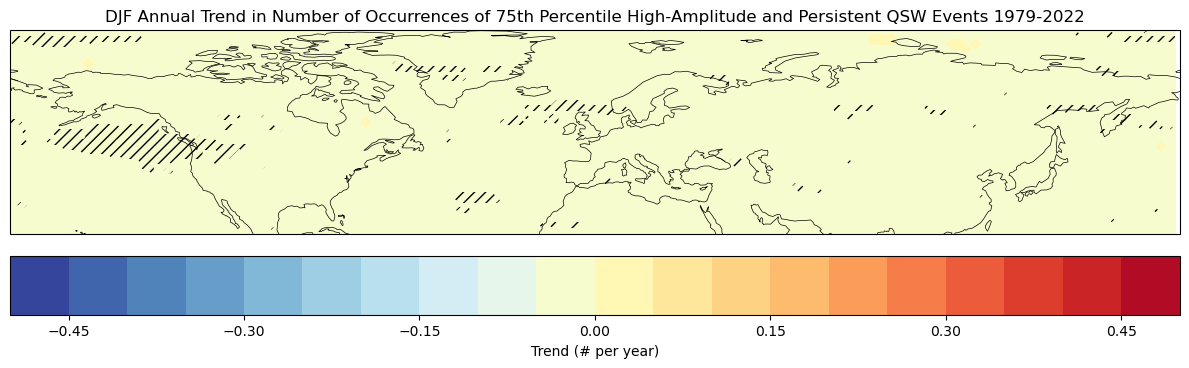

In [37]:
# plotting trend map
# separate lats and lons
lats = sorted(set(k[0] for k in trends))
lons = sorted(set(k[1] for k in trends))

# create empty 2D array and fill it
trend_array = np.full((len(lats), len(lons)), np.nan)

for (lat, lon), value in trends.items():
    i = lats.index(lat)
    j = lons.index(lon)
    trend_array[i, j] = value

# create lat lon meshgrid
lon2d, lat2d = np.meshgrid(lons, lats)

fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

c = ax.contourf(lon2d, lat2d, trend_array,
                levels=np.linspace(-0.5, 0.5, 21),
                cmap='RdYlBu_r',
                transform=ccrs.PlateCarree())
ax.set_title("DJF Annual Trend in Number of Occurrences of 75th Percentile High-Amplitude and Persistent QSW Events 1979-2022")
ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend (# per year)")

# mask p < 0.05 with hatching
sig_mask = (pval_array < 0.05)
ax.contourf(lon2d, lat2d, sig_mask, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()
# vmax=+-0.1

# When minimum temperatures are occurring at the same time as 90th percentile QSWs

In [22]:
# convert all temps to C
def k_to_c(x):
    return x - 273.15

daily_min_c = daily_min.copy()
daily_min_c = daily_min.apply(k_to_c)
daily_min_c

<xarray.Dataset> Size: 163MB
Dimensions:    (time: 3940, longitude: 240, latitude: 43)
Coordinates:
  * time       (time) datetime64[ns] 32kB 1979-01-01 1979-01-02 ... 2022-02-28
  * longitude  (longitude) float64 2kB -180.0 -178.5 -177.0 ... 177.0 178.5
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
Data variables:
    t2m        (time, latitude, longitude) float32 163MB -25.83 -25.83 ... 24.01

In [23]:
# first, average QSW amplitudes across Pacific Coast
pacific_qsw = winter_qsw.sel(latitude=slice(55, 40), longitude=slice(-160, -120), time=winter_qsw.time.dt.month.isin([12,1,2]))
pacific_qsw_avg = pacific_qsw.mean(dim={"latitude", "longitude"}, skipna=True)
pacific_qsw_avg

<xarray.Dataset> Size: 81kB
Dimensions:    (time: 3355)
Coordinates:
  * time       (time) datetime64[ns] 27kB 1979-01-08 1979-01-09 ... 2022-12-24
    dayofyear  (time) int64 27kB ...
Data variables:
    q          (time) float64 27kB 8.762 7.434 5.97 4.784 ... 9.737 8.889 8.205

In [24]:
# filter dataset to obtain times of 90th percentile high-amplitude QSWs across Pacific Coast
pacific_avg_90 = pacific_qsw_avg.quantile(q=0.9)["q"].item()
amp_90_pacific = pacific_qsw_avg.copy()
mask = pacific_qsw_avg["q"] > pacific_avg_90
amp_90_pacific["q"] = amp_90_pacific["q"][mask]
amp_90_pacific = amp_90_pacific.dropna(dim="time")
amp_90_pacific

<xarray.Dataset> Size: 8kB
Dimensions:    (time: 336)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1979-01-27 1979-01-28 ... 2022-12-11
    dayofyear  (time) int64 3kB ...
Data variables:
    q          (time) float64 3kB 20.67 22.62 23.66 23.56 ... 21.61 21.38 20.04

In [25]:
# restrict daily_min to North America
na_daily_min = daily_min_c.sel(latitude=slice(85, 20), longitude=slice(-180, -50), time=daily_min.time.dt.month.isin([12,1,2]))
na_daily_min

<xarray.Dataset> Size: 59MB
Dimensions:    (time: 3940, longitude: 87, latitude: 43)
Coordinates:
  * time       (time) datetime64[ns] 32kB 1979-01-01 1979-01-02 ... 2022-02-28
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
Data variables:
    t2m        (time, latitude, longitude) float32 59MB -25.83 -25.83 ... 22.96

In [26]:
# daily minimum temperatures in North America when 90th percentile high-amplitude waves are occurring on Pacific Coast
daily_min_90 = na_daily_min.sel(time = na_daily_min.time.isin(amp_90_pacific.time))
daily_min_90 = daily_min_90.sortby(daily_min_90.time)
daily_min_90

<xarray.Dataset> Size: 5MB
Dimensions:    (time: 331, longitude: 87, latitude: 43)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1979-01-27 1979-01-28 ... 2021-12-24
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
Data variables:
    t2m        (time, latitude, longitude) float32 5MB -27.52 -27.35 ... 23.65

In [27]:
# groupby year
daily_min_90_yearly = daily_min_90.groupby("time.year").mean(dim='time', skipna=True)
daily_min_90_yearly

<xarray.Dataset> Size: 570kB
Dimensions:    (year: 38, latitude: 43, longitude: 87)
Coordinates:
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * year       (year) int64 304B 1979 1981 1982 1984 ... 2018 2019 2020 2021
Data variables:
    t2m        (year, latitude, longitude) float32 569kB -32.65 -32.63 ... 23.56

In [28]:
# calculate trends
slope_tmin, pval_tmin = xr.apply_ufunc(
    manntrend,
    daily_min_90_yearly,
    input_core_dims=[['year']],
    output_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float]
)

slope_tmin

<xarray.Dataset> Size: 31kB
Dimensions:    (latitude: 43, longitude: 87)
Coordinates:
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
Data variables:
    t2m        (latitude, longitude) float64 30kB 0.1021 0.1071 ... 0.005351

## Average Daily Minimum Temperatures (DJF, North America, 1979-2022)

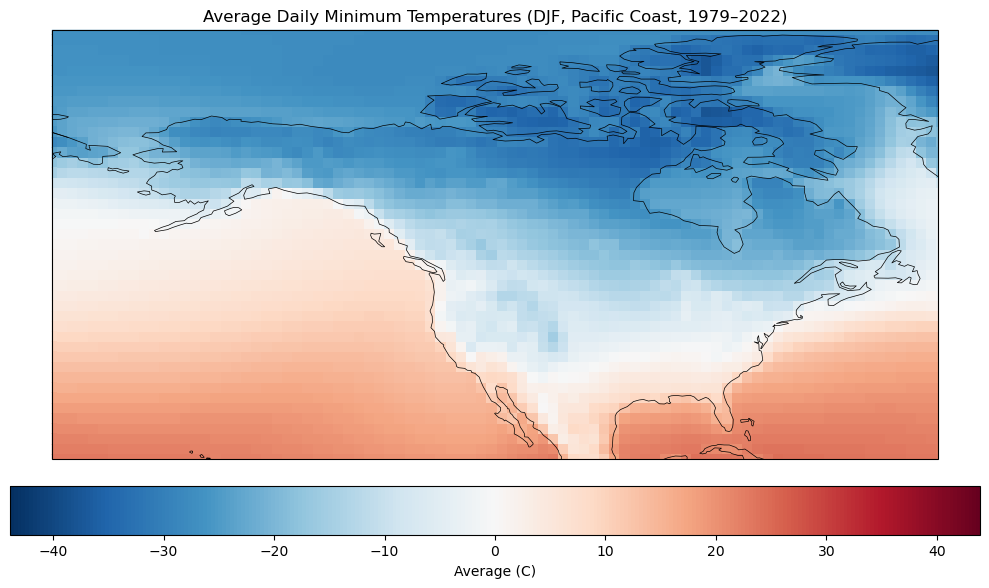

In [52]:
# average daily min temperatures 1979-2022
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

var = daily_min_c["t2m"].mean(dim="time")

c = var.plot(ax=ax, cmap="RdBu_r", transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title("Average Daily Minimum Temperatures (DJF, Pacific Coast, 1979–2022)")
ax.set_extent([-180, -50, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Average (C)")

plt.tight_layout()
plt.show()

## Anomaly in Mean Daily Minimum Temperatures during 90th percentile QSWs occurring on the Pacific Coast (DJF, North America, 1979-2022)

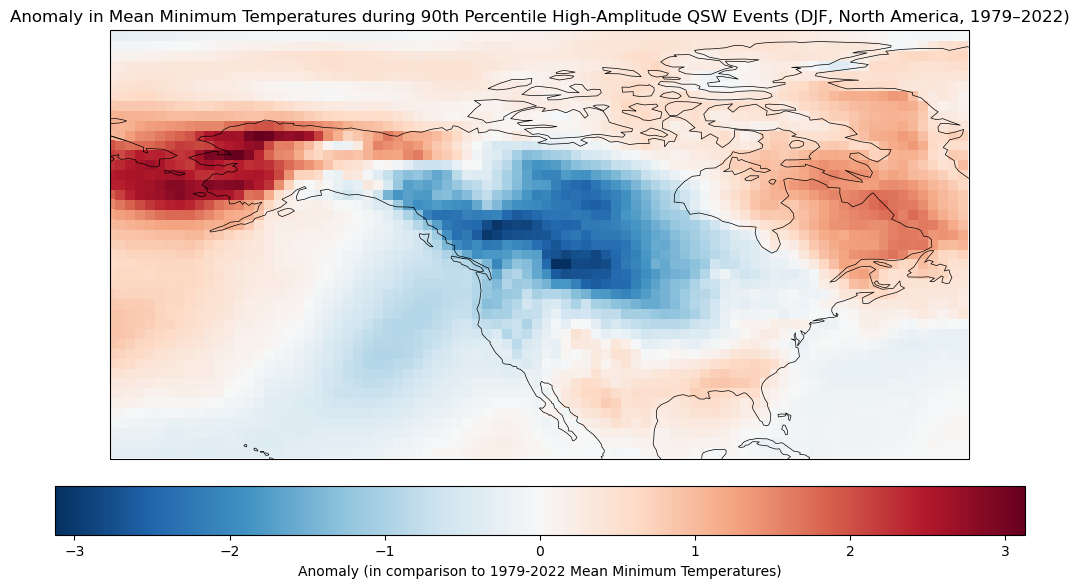

In [33]:
# average daily min temperatures during 90th percentile QSWs 1979-2022 on the Pacific Coast
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

var = daily_min_90["t2m"].mean(dim="time") - daily_min_c["t2m"].mean(dim="time")

c = var.plot(ax=ax, cmap="RdBu_r", transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title("Anomaly in Mean Minimum Temperatures during 90th Percentile High-Amplitude QSW Events (DJF, North America, 1979–2022)")
ax.set_extent([-180, -50, 20, 85], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Anomaly (in comparison to 1979-2022 Mean Minimum Temperatures)")

plt.tight_layout()
plt.show()

## Annual Trend in Mean Daily Minimum Temperatures during 90th percentile QSWs occurring on the Pacific Coast (DJF, North America, 1979-2022)

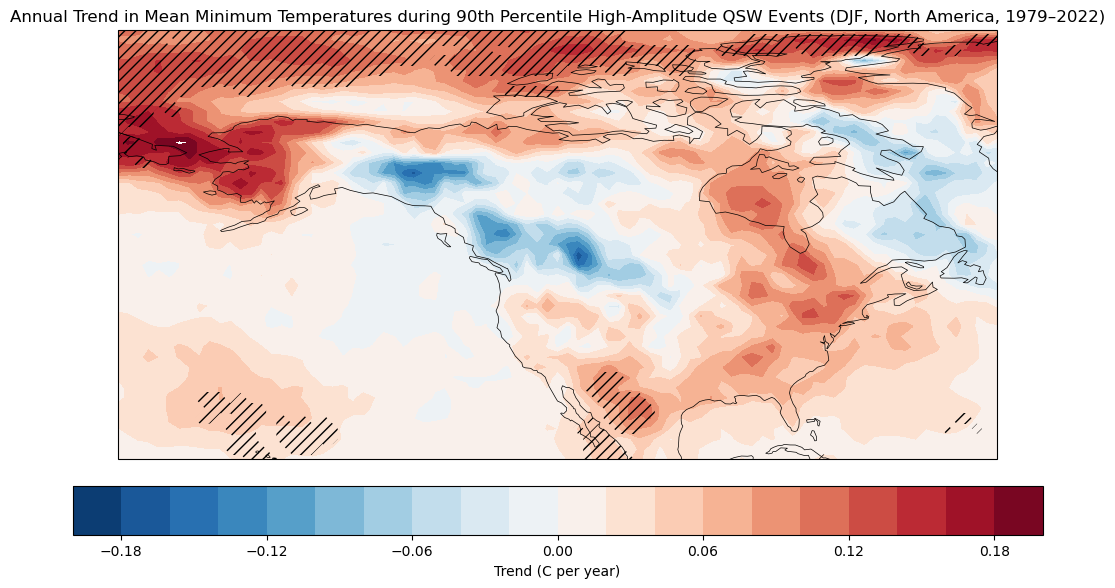

In [36]:
# plot trend map
lon2d, lat2d = np.meshgrid(daily_min_90_yearly.longitude, daily_min_90_yearly.latitude)
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

c = ax.contourf(slope_tmin.longitude,
                slope_tmin.latitude,
                slope_tmin.t2m,
                levels=np.linspace(-0.2, 0.2, 21),
                cmap="RdBu_r",
                transform=ccrs.PlateCarree())
ax.set_title("Annual Trend in Mean Minimum Temperatures during 90th Percentile High-Amplitude QSW Events (DJF, North America, 1979–2022)")
ax.set_extent([-180, -51, 21, 84], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Trend (C per year)")

# mask p < 0.05 with hatching
sig_mask = (pval_tmin["t2m"] < 0.05)
ax.contourf(lon2d, lat2d, sig_mask, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

## Anomaly in Trend of MinTemp during 90th percentile - Normal Trend of MinTemp

In [29]:
na_daily_min_yearly = na_daily_min.groupby("time.year").mean(dim='time', skipna=True)
na_daily_min_yearly

<xarray.Dataset> Size: 660kB
Dimensions:    (year: 44, latitude: 43, longitude: 87)
Coordinates:
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * year       (year) int64 352B 1979 1980 1981 1982 ... 2019 2020 2021 2022
Data variables:
    t2m        (year, latitude, longitude) float32 658kB -29.39 -29.4 ... 22.8

In [30]:
# calculate trends
slope_tmin1, pval_tmin1 = xr.apply_ufunc(
    manntrend,
    na_daily_min_yearly,
    input_core_dims=[['year']],
    output_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float]
)

slope_tmin1

<xarray.Dataset> Size: 31kB
Dimensions:    (latitude: 43, longitude: 87)
Coordinates:
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
Data variables:
    t2m        (latitude, longitude) float64 30kB 0.08017 0.07851 ... 0.01251

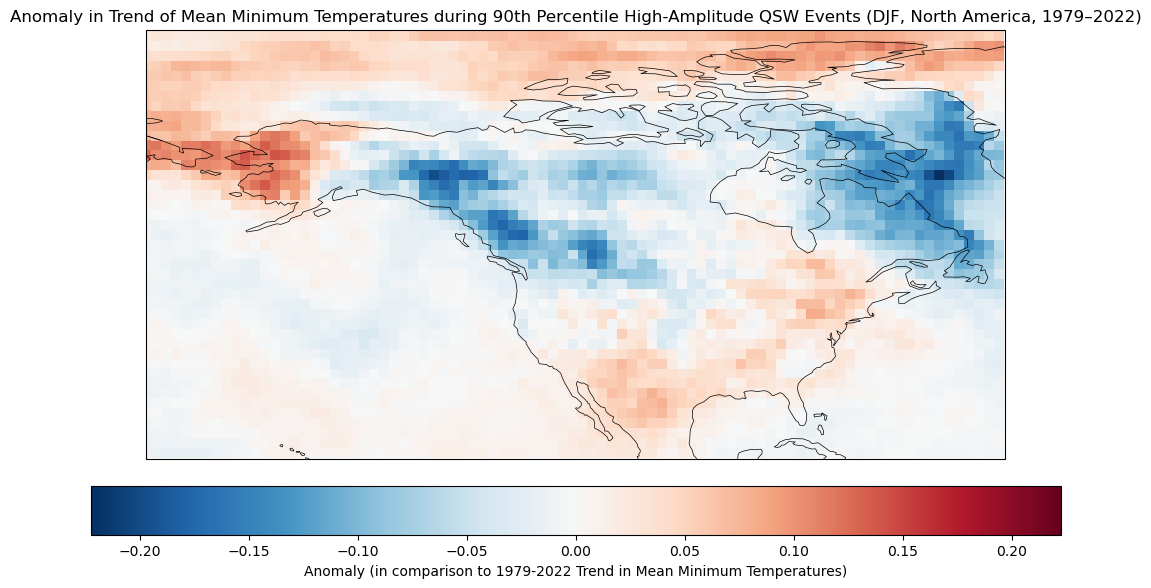

In [34]:
# anomaly in trend of min temps
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

anomaly_daily_min_90 = slope_tmin["t2m"] - slope_tmin1["t2m"]

c = anomaly_daily_min_90.plot(ax=ax, cmap="RdBu_r", transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title("Anomaly in Trend of Mean Minimum Temperatures during 90th Percentile High-Amplitude QSW Events (DJF, North America, 1979–2022)")
ax.set_extent([-180, -50, 20, 85], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Anomaly (in comparison to 1979-2022 Trend in Mean Minimum Temperatures)")

plt.tight_layout()
plt.show()

# When cold wave days are occurring at the same time as 90th percentile QSWs

In [35]:
# first, average QSW amplitudes across Pacific Coast
pacific_qsw = winter_qsw.sel(latitude=slice(55, 40), longitude=slice(-160, -120), time=winter_qsw.time.dt.month.isin([12,1,2]))
pacific_qsw_avg = pacific_qsw.mean(dim={"latitude", "longitude"}, skipna=True)
pacific_qsw_avg

<xarray.Dataset> Size: 81kB
Dimensions:    (time: 3355)
Coordinates:
  * time       (time) datetime64[ns] 27kB 1979-01-08 1979-01-09 ... 2022-12-24
    dayofyear  (time) int64 27kB ...
Data variables:
    q          (time) float64 27kB 8.762 7.434 5.97 4.784 ... 9.737 8.889 8.205

In [36]:
# filter dataset to obtain times of 90th percentile high-amplitude QSWs across Pacific Coast
pacific_avg_90 = pacific_qsw_avg.quantile(q=0.9)["q"].item()
amp_90_pacific = pacific_qsw_avg.copy()
mask = pacific_qsw_avg["q"] > pacific_avg_90
amp_90_pacific["q"] = amp_90_pacific["q"][mask]
amp_90_pacific = amp_90_pacific.dropna(dim="time")
amp_90_pacific

<xarray.Dataset> Size: 8kB
Dimensions:    (time: 336)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1979-01-27 1979-01-28 ... 2022-12-11
    dayofyear  (time) int64 3kB ...
Data variables:
    q          (time) float64 3kB 20.67 22.62 23.66 23.56 ... 21.61 21.38 20.04

In [37]:
# restrict coldwave_winter to North America
na_coldwave_winter = coldwave_winter.sel(latitude=slice(85, 20), longitude=slice(-180, -50), time=coldwave_winter.time.dt.month.isin([12,1,2]))
na_coldwave_winter

<xarray.Dataset> Size: 115MB
Dimensions:    (time: 3856, longitude: 87, latitude: 43)
Coordinates:
  * time       (time) object 31kB 1979-12-08 00:00:00 ... 2022-02-21 00:00:00
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
    dayofyear  (time) int64 31kB ...
Data variables:
    t2m        (time, latitude, longitude) float64 115MB ...

## Anomaly in Mean Frequency of Cold Wave Days during 90th percentile QSWs occurring on the Pacific Coast (DJF, North America, 1979-2022) (IGNORE)

In [41]:
def persist(dat):
    count = 0
    perch = np.full(len(dat), np.nan)
    for i, val in enumerate(dat):
        if val == 1:
            count += 1
        elif count > 0:
            perch[i] = count
            count = 0
    return perch
    
# coldwave_lens = xr.apply_ufunc(
#     persist,
#     na_coldwave_winter.t2m,  # your 0-1 mask where 1 = extreme
#     input_core_dims=[['time']],
#     output_core_dims=[['time']],
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[object]
# )
na_coldwave_winter["t2m"] = xr.apply_ufunc(
    persist,
    na_coldwave_winter.t2m,  # your 0-1 mask where 1 = extreme
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[object]
)

# yrper = persist_ht.groupby('time.year').mean()#[10,75,:].values[-800:]
na_coldwave_winter

<xarray.Dataset> Size: 115MB
Dimensions:    (time: 3856, longitude: 87, latitude: 43)
Coordinates:
  * time       (time) object 31kB 1979-12-08 00:00:00 ... 2022-02-21 00:00:00
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
    dayofyear  (time) int64 31kB ...
Data variables:
    t2m        (latitude, longitude, time) object 115MB nan nan nan ... nan 3.0

In [42]:
# na_coldwave = na_coldwave_winter.where(na_coldwave_winter["t2m"] == 1, drop=True)
na_coldwave = na_coldwave_winter.where(na_coldwave_winter["t2m"] > 0, drop=True)
na_coldwave

<xarray.Dataset> Size: 108MB
Dimensions:    (latitude: 43, longitude: 87, time: 3613)
Coordinates:
  * time       (time) object 29kB 1979-12-09 00:00:00 ... 2022-02-21 00:00:00
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
    dayofyear  (time) int64 29kB 343 344 345 346 347 348 ... 47 48 49 50 51 52
Data variables:
    t2m        (latitude, longitude, time) object 108MB nan nan nan ... nan 3.0

In [43]:
# convert amp_90 times to noleap for comparison
amp_90_pacific_noleap = amp_90_pacific.convert_calendar('noleap')

# cold wave days in North America when 90th percentile high-amplitude waves are occurring on Pacific Coast
na_coldwave_90 = na_coldwave.sel(time = na_coldwave.time.isin(amp_90_pacific_noleap.time))
na_coldwave_90 = na_coldwave_90.sortby(na_coldwave_90.time)
na_coldwave_90

<xarray.Dataset> Size: 9MB
Dimensions:    (latitude: 43, longitude: 87, time: 308)
Coordinates:
  * time       (time) object 2kB 1981-12-07 00:00:00 ... 2021-12-24 00:00:00
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
    dayofyear  (time) int64 2kB 341 342 343 20 33 34 ... 352 353 355 356 357 358
Data variables:
    t2m        (latitude, longitude, time) object 9MB nan nan nan ... nan nan

/home/nedroos/.conda/envs/nazenv_py.3.13.4/lib/python3.1/site-packages/xarray/computation/nanops.py:118: RuntimeWarning: invalid value encountered in divide
  data = data / (valid_count - ddof)


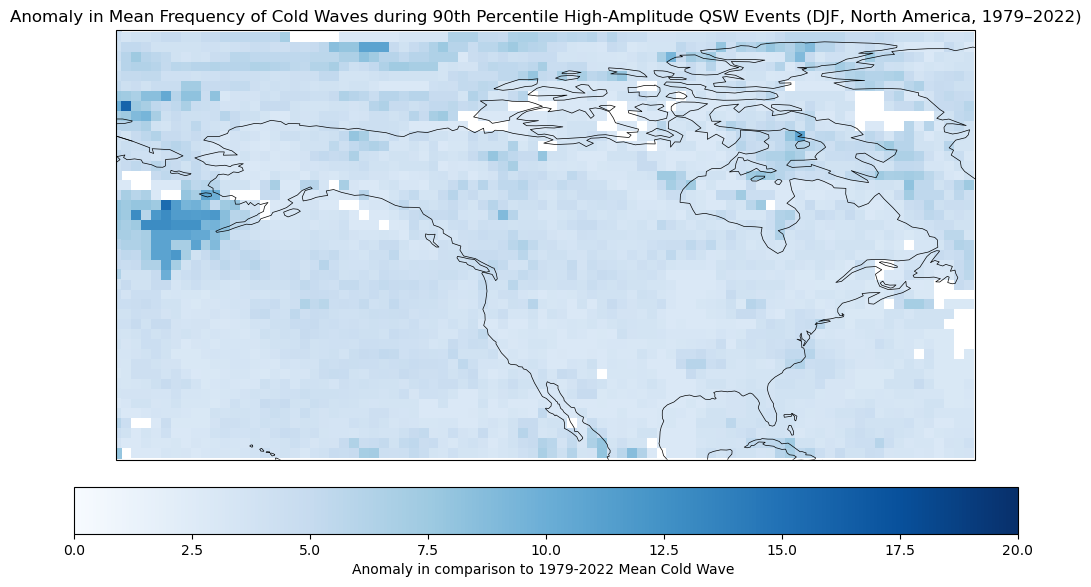

In [44]:
# average frequency of cold wave days during 90th percentile QSWs 1979-2022 on the Pacific Coast
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
vmin=0
vmax=20

var = na_coldwave_90["t2m"].mean(dim="time") - coldwave_winter["t2m"].mean(dim="time")

c = var.plot(ax=ax, cmap="Blues", transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin, vmax=vmax)
ax.set_title("Anomaly in Mean Frequency of Cold Waves during 90th Percentile High-Amplitude QSW Events (DJF, North America, 1979–2022)")
ax.set_extent([-180, -50, 20, 85], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Anomaly in comparison to 1979-2022 Mean Cold Wave ")

plt.tight_layout()
plt.show()

## Anomaly in mean number of coldwave days

In [38]:
# convert amp_90 times to noleap for comparison
amp_90_pacific_noleap = amp_90_pacific.convert_calendar('noleap')

# cold wave days in North America when 90th percentile high-amplitude waves are occurring on Pacific Coast
na_coldwave_90 = na_coldwave_winter.sel(time = na_coldwave_winter.time.isin(amp_90_pacific_noleap.time))
na_coldwave_90 = na_coldwave_90.sortby(na_coldwave_90.time)
na_coldwave_90

<xarray.Dataset> Size: 10MB
Dimensions:    (time: 318, longitude: 87, latitude: 43)
Coordinates:
  * time       (time) object 3kB 1981-12-07 00:00:00 ... 2021-12-24 00:00:00
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
    dayofyear  (time) int64 3kB ...
Data variables:
    t2m        (time, latitude, longitude) float64 10MB ...

In [39]:
var = na_coldwave_90["t2m"].mean(dim="time") - na_coldwave_winter["t2m"].mean(dim="time")
var

<xarray.DataArray 't2m' (latitude: 43, longitude: 87)> Size: 30kB
array([[-2.33059970e-02, -2.54133067e-02, -2.61913150e-02, ...,
        -4.85888202e-03, -6.93357081e-03,  2.75972755e-03],
       [-1.60772071e-02, -9.49594196e-03, -9.75527806e-03, ...,
        -2.30792818e-02, -2.28199457e-02, -1.36126987e-02],
       [-1.70493097e-02, -1.83459902e-02, -1.78273180e-02, ...,
        -1.62713014e-02, -1.75679819e-02, -2.23012735e-02],
       ...,
       [-9.52856285e-03, -5.83261567e-03, -1.78925598e-02, ...,
         7.71810329e-03, -9.46005898e-05,  9.42743809e-04],
       [-3.21315796e-04, -1.32603930e-03, -6.05933088e-03, ...,
         1.61147212e-02,  2.00373835e-02, -1.71585897e-03],
       [-4.50331428e-03, -5.50803779e-03,  2.29977296e-04, ...,
         1.87080822e-02, -4.08250476e-03, -1.26732169e-02]],
      shape=(43, 87))
Coordinates:
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0

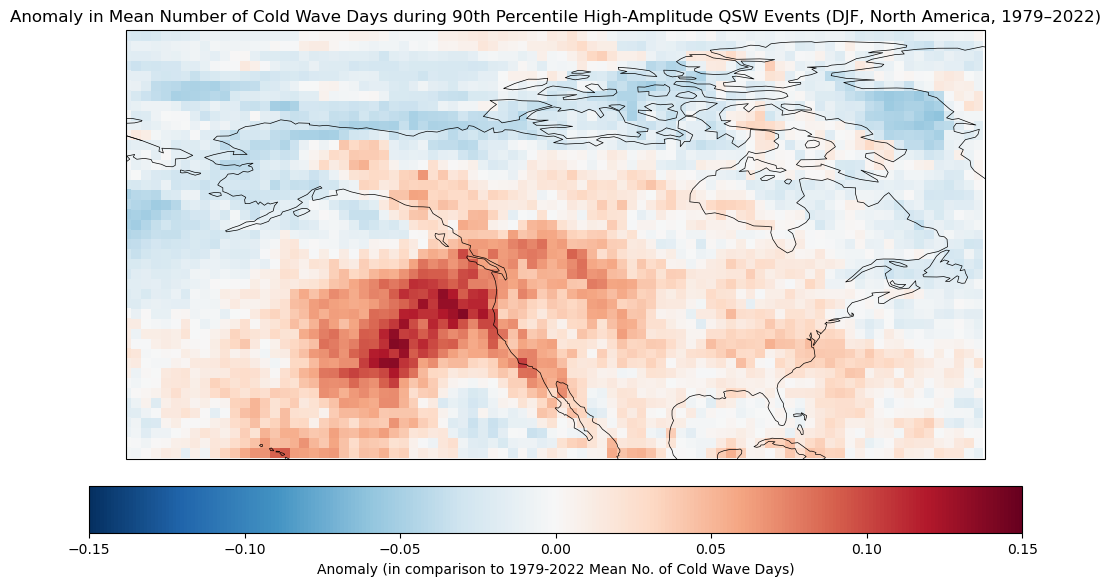

In [41]:
# anomaly in mean number of cold wave days
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
vmin=-0.15
vmax=0.15

c = var.plot(ax=ax, cmap="RdBu_r", transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin, vmax=vmax)
ax.set_title("Anomaly in Mean Number of Cold Wave Days during 90th Percentile High-Amplitude QSW Events (DJF, North America, 1979–2022)")
ax.set_extent([-180, -50, 20, 85], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Anomaly (in comparison to 1979-2022 Mean No. of Cold Wave Days)")

plt.tight_layout()
plt.show()

## Anomaly in Trend of Avg # of Cold Wave days during 90th percentile QSWs

In [44]:
# when 90th
na_coldwave_90_yearly = na_coldwave_90.groupby("time.year").mean(dim='time', skipna=True)
na_coldwave_90_yearly

<xarray.Dataset> Size: 1MB
Dimensions:    (year: 37, latitude: 43, longitude: 87)
Coordinates:
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * year       (year) int64 296B 1981 1982 1984 1985 ... 2018 2019 2020 2021
Data variables:
    t2m        (year, latitude, longitude) float64 1MB 0.0 0.0 0.0 ... 0.0 0.0

In [47]:
# not when 90th
na_coldwave_yearly = na_coldwave_winter.groupby("time.year").mean(dim='time', skipna=True)
na_coldwave_yearly = na_coldwave_yearly.sel(year = na_coldwave_yearly.year.isin(na_coldwave_90_yearly.year))
na_coldwave_yearly

<xarray.Dataset> Size: 1MB
Dimensions:    (year: 37, latitude: 43, longitude: 87)
Coordinates:
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
  * year       (year) int64 296B 1981 1982 1984 1985 ... 2018 2019 2020 2021
Data variables:
    t2m        (year, latitude, longitude) float64 1MB 0.01111 0.01111 ... 0.0

In [48]:
# calculate trends
slope_days, pval_days = xr.apply_ufunc(
    manntrend,
    na_coldwave_90_yearly,
    input_core_dims=[['year']],
    output_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float]
)

slope_days1, pval_days1 = xr.apply_ufunc(
    manntrend,
    na_coldwave_yearly,
    input_core_dims=[['year']],
    output_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float]
)

slope_days1

<xarray.Dataset> Size: 31kB
Dimensions:    (latitude: 43, longitude: 87)
Coordinates:
  * longitude  (longitude) float64 696B -180.0 -178.5 -177.0 ... -52.5 -51.0
  * latitude   (latitude) float64 344B 84.0 82.5 81.0 79.5 ... 24.0 22.5 21.0
Data variables:
    t2m        (latitude, longitude) float64 30kB -0.001389 ... -0.00114

In [56]:
slope_days.max()

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    t2m      float64 8B 0.0

In [ ]:
# anomaly in trend of mean number of cold wave days
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
vmin=-0.005
vmax=0.01

var = 

c = var.plot(ax=ax, cmap="RdBu_r", transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin, vmax=vmax)
ax.set_title("Anomaly in Mean Number of Cold Wave Days during 90th Percentile High-Amplitude QSW Events (DJF, North America, 1979–2022)")
ax.set_extent([-180, -50, 20, 85], crs=ccrs.PlateCarree())
ax.add_feature(coastline)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Anomaly (in comparison to 1979-2022 Mean No. of Cold Wave Days)")

plt.tight_layout()
plt.show()

# Unused code

In [60]:
# # reduce t2m to find where t2m == 1 at any grid cell
# coldwave_mask = (coldwave_winter["t2m"] == 1)
# coldwave_any = coldwave_mask.any(dim=["latitude", "longitude"])
# coldwave_times = coldwave_winter.time.where(coldwave_any, drop=True)
# coldwave_times

In [61]:
# # convert both datasets to noleap + truncate times values to just date
# amp_times = np.array(amp_90_pacific.convert_calendar('noleap').time.dt.floor("D"))
# cold_times = np.array(coldwave_times.time.dt.floor("D"))

# # intersect dates
# common_times = np.intersect1d(amp_times, cold_times)
# common_times

In [62]:
# # select intersected times from both datasets; now both datasets have times when both are occurring but with different values
# # amplitudes
# amp_90_pacific_noleap = amp_90_noleap.sel(time = amp_90_noleap.time.isin(common_times))
# # cold wave occurrence
# coldwave_pacific = coldwave_winter_noleap.sel(latitude=slice(84, 35), longitude=slice(-180, -110))
# coldwave_90 = coldwave_pacific.sel(time=coldwave_pacific.time.isin(common_times))
# coldwave_90

In [63]:
# # masking high-amp times to match cold-wave times
# amp_90_pacific_noleap = amp_90_pacific.convert_calendar('noleap')
# time_mask = amp_90_pacific_noleap["time"].isin(coldwave_winter.time.values)

# # select times in coldwave_winter
# amp_90_pacific_noleap = amp_90_pacific_noleap.sel(time=time_mask)

# amp_90_pacific_noleap

In [64]:
# # what months are occurring in these datasets???
# months = coldwave_winter['time.month'].rename('month')
# month_count = {key: 0 for key in range(1, 13)}
# for m in months:
#     month_count[m.item()] += 1

# month_count

In [65]:
# # to get 90th percentile of average high-amplitude QSWs across Pacific Coast when cold waves are occurring
# coldwave_90 = coldwave_pacific.where(coldwave_pacific["time"].isin(amp_90_pacific_noleap.time)).dropna(dim="time")
# coldwave_90

In [66]:
# # groupby year -> dataset showing the yearly average of 90th percentile high-amplitude + cold waves across Pacific Coast
# coldwave_90_yearly = coldwave_90.groupby("time.year").sum()
# coldwave_90_yearly

In [67]:
# group by year and average amplitude per year
# qsw_during_coldwave90_yearly = qsw_during_coldwave90_avg.groupby("time.year").mean()
# qsw_during_coldwave90_yearly

In [68]:
# # select matching times in original QSW dataset (not the average), then avg over lat/lon
# winter_qsw_noleap = winter_qsw.convert_calendar('noleap')
# qsw_during_coldwave90 = winter_qsw_noleap.sel(
#     latitude=slice(84, 35),
#     longitude=slice(-180, -110),
#     time=winter_qsw_noleap.time.isin(common_times)
# )
# qsw_during_coldwave90_yearly = qsw_during_coldwave90.copy()
# qsw_during_coldwave90_yearly["q"] = qsw_during_coldwave90["q"].groupby("time.year").mean(dim="time", skipna=True)

# qsw_during_coldwave90_yearly

# Plots for presentation

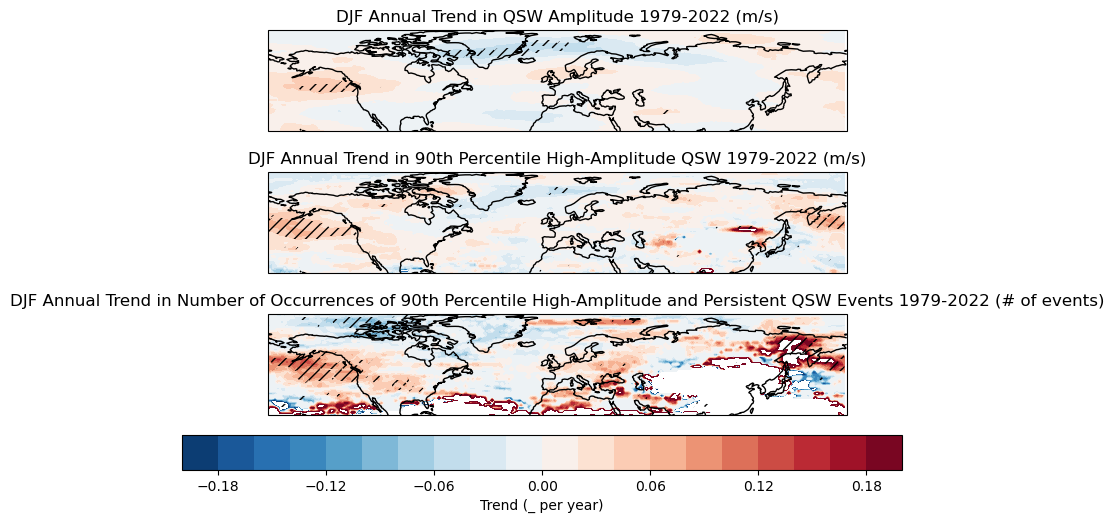

In [106]:
fig, axs = plt.subplots(3, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

dataset_lons = [winter_qsw_yearly.longitude, amp_90_winter_qsw_yearly.longitude, lons]
dataset_lats = [winter_qsw_yearly.latitude, amp_90_winter_qsw_yearly.latitude, lats]
longs = [slope1.longitude, slope2.longitude, lon2d_p]
latis = [slope1.latitude, slope2.latitude, lat2d_p]
qs = [slope1.q, slope2.q, trend3]
pvals = [pval1["q"], pval2["q"], pval3]
titles = ["DJF Annual Trend in QSW Amplitude 1979-2022 (m/s)",
          "DJF Annual Trend in 90th Percentile High-Amplitude QSW 1979-2022 (m/s)",
          "DJF Annual Trend in Number of Occurrences of 90th Percentile High-Amplitude and Persistent QSW Events 1979-2022 (# of events)"]

# define consistent color scale
vmin, vmax = -0.2, 0.2
levels = np.linspace(vmin, vmax, 21)

for ax, ds_lon, ds_lat, lon, lat, q, pval, title in zip(axs, dataset_lons, dataset_lats, longs, latis, qs, pvals, titles):
    lon2d, lat2d = np.meshgrid(ds_lon, ds_lat)
    c = ax.contourf(
        lon,
        lat,
        q,
        levels=levels,
        cmap="RdBu_r",
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree()
    )

    sig_mask = (pval < 0.05)
    ax.contourf(lon2d, lat2d, sig_mask, levels=[0.5, 1.5],
                colors='none', hatches=['///'], transform=ccrs.PlateCarree())

    ax.set_title(title)
    ax.set_extent([-180, 180, 21, 84], crs=ccrs.PlateCarree())
    ax.coastlines()

# shared colorbar
cbar_ax = fig.add_axes([0.2, 0.001, 0.6, 0.07])
cbar = fig.colorbar(c, cax=cbar_ax, orientation="horizontal", pad=0.4)
cbar.set_label("Trend (_ per year)")

# plt.tight_layout()
fig.subplots_adjust(hspace=0.4)
plt.show()